In [1]:
# 01_imports_week5.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor



In [2]:
# Libraries and plotting config
import os, sys
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import folium
from folium.plugins import MarkerCluster
import networkx as nx

# Matplotlib inline
%matplotlib inline
sns.set(style="whitegrid")


In [3]:
# 02_load_week5.py
df = pd.read_parquet("/content/flights_cleaned_week2.parquet")
print("Shape:", df.shape)


Shape: (100000, 51)


In [4]:
# to load fast parquet if present; else use sample CSV zip
data = None
parquet_path = "/content/flights_cleaned_week2.parquet"
csv_zip_path = "/content/flights_sample_100k.csv.zip"
if os.path.exists(parquet_path):
    print("Loading parquet:", parquet_path)
    data = pd.read_parquet(parquet_path)
elif os.path.exists(csv_zip_path):
    print("Loading CSV from zip:", csv_zip_path)
    data = pd.read_csv(csv_zip_path, compression='zip')
else:
    raise FileNotFoundError("No data file found at expected paths.")

# quick peek
print("Rows, cols:", data.shape)
data.head()


Loading parquet: /content/flights_cleaned_week2.parquet
Rows, cols: (100000, 51)


FL_DATE               AIRLINE               AIRLINE_DOT AIRLINE_CODE  \
0  2019-02-15     Endeavor Air Inc.     Endeavor Air Inc.: 9E           9E   
1  2019-04-15     Endeavor Air Inc.     Endeavor Air Inc.: 9E           9E   
2  2019-07-29  Delta Air Lines Inc.  Delta Air Lines Inc.: DL           DL   
3  2019-10-14     Endeavor Air Inc.     Endeavor Air Inc.: 9E           9E   
4  2020-02-05     Endeavor Air Inc.     Endeavor Air Inc.: 9E           9E   

   DOT_CODE  FL_NUMBER ORIGIN                     ORIGIN_CITY DEST  \
0     20363       5443    ABE  Allentown/Bethlehem/Easton, PA  ATL   
1     20363       5443    ABE  Allentown/Bethlehem/Easton, PA  ATL   
2     19790        518    ABE  Allentown/Bethlehem/Easton, PA  ATL   
3     20363       5172    ABE  Allentown/Bethlehem/Easton, PA  ATL   
4     20363       5197    ABE  Allentown/Bethlehem/Easton, PA  ATL   

     DEST_CITY  ...  cancellation_code  time_of_day          ACTUAL_DEP  \
0  Atlanta, GA  ...                NaN      evening 2019-02-15 17:48:00   
1  Atlanta, GA  ...                NaN      evening 2019-04-15 17:47:00   
2  Atlanta, GA  ...                NaN      morning 2019-07-29 06:05:00   
3  Atlanta, GA  ...                NaN    afternoon 2019-10-14 12:55:00   
4  Atlanta, GA  ...                NaN      evening 2020-02-05 17:37:00   

   dep_delay_minutes_calc  route_delay_roll5  ORIGIN_freq  DEST_freq  \
0                    -5.0         -18.000000      0.00085    0.05095   
1                   -11.0         -19.500000      0.00085    0.05095   
2                    -5.0         -13.666667      0.00085    0.05095   
3                    -8.0         -16.500000      0.00085    0.05095   
4                    -5.0         -18.600000      0.00085    0.05095   

   ORIGIN_code  DEST_code  time_of_day_code  
0            0         20                 1  
1            0         20                 1  
2            0         20                 2  
3            0         20                 0  
4            0         20                 1  

[5 rows x 51 columns]

In [5]:
# 03_target_classification.py
df['delay_class'] = (df['ARR_DELAY'] > 15).astype(int)
print("Delay class distribution:\n", df['delay_class'].value_counts(normalize=True))


Delay class distribution:
 delay_class
0    0.82618
1    0.17382
Name: proportion, dtype: float64


In [6]:
# 04_target_regression.py
df['delay_reg'] = df['ARR_DELAY'].fillna(0)
print(df['delay_reg'].describe())


count    100000.000000
mean          4.229590
std          50.626984
min         -88.000000
25%         -15.000000
50%          -6.000000
75%           6.000000
max        1520.000000
Name: delay_reg, dtype: float64


In [7]:
# 05_features.py
features = []
for col in ['DEP_DELAY','DISTANCE','hour','day_of_week','month','OP_CARRIER','ORIGIN','DEST']:
    if col in df.columns:
        features.append(col)
print("Features selected:", features)


Features selected: ['DEP_DELAY', 'DISTANCE', 'hour', 'day_of_week', 'month', 'ORIGIN', 'DEST']


In [8]:
# 06_encoding.py
df_enc = pd.get_dummies(df[features], drop_first=True)
print("Encoded feature shape:", df_enc.shape)


Encoded feature shape: (100000, 751)


In [9]:
# 07_train_test_split_class.py
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(df_enc, df['delay_class'], test_size=0.2, random_state=42, stratify=df['delay_class'])
print("Train size:", X_train_c.shape, "Test size:", X_test_c.shape)


Train size: (80000, 751) Test size: (20000, 751)


In [10]:
# 08_train_test_split_reg.py
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(df_enc, df['delay_reg'], test_size=0.2, random_state=42)
print("Train size:", X_train_r.shape, "Test size:", X_test_r.shape)


Train size: (80000, 751) Test size: (20000, 751)


In [11]:
# 09_logistic_regression.py
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# Create a pipeline with an imputer and the logistic regression model
log_reg = Pipeline([
    ('imputer', SimpleImputer(strategy='median')), # Impute missing values with the median
    ('logistic_regression', LogisticRegression(max_iter=1000))
])

log_reg.fit(X_train_c, y_train_c)
y_pred_c = log_reg.predict(X_test_c)
print("Logistic Regression Accuracy:", accuracy_score(y_test_c, y_pred_c))

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy: 0.93595


<Figure size 600x600 with 0 Axes>

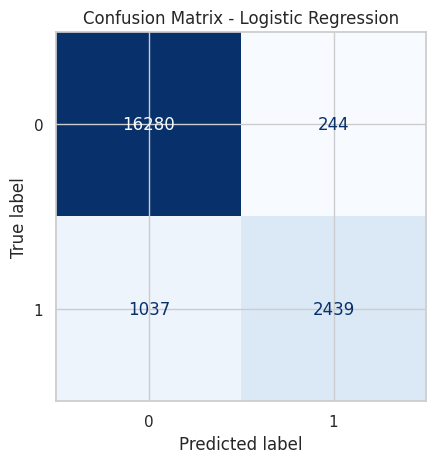

In [12]:
# Visualize Confusion Matrix for Logistic Regression
plt.figure(figsize=(6,6))
ConfusionMatrixDisplay.from_estimator(log_reg, X_test_c, y_test_c, cmap='Blues', colorbar=False)
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

In [13]:
# 10_decision_tree_classifier.py
tree_c = DecisionTreeClassifier(max_depth=8, random_state=1)
tree_c.fit(X_train_c, y_train_c)
y_pred_tree = tree_c.predict(X_test_c)
print("Decision Tree Accuracy:", accuracy_score(y_test_c, y_pred_tree))


Decision Tree Accuracy: 0.9351


<Figure size 600x600 with 0 Axes>

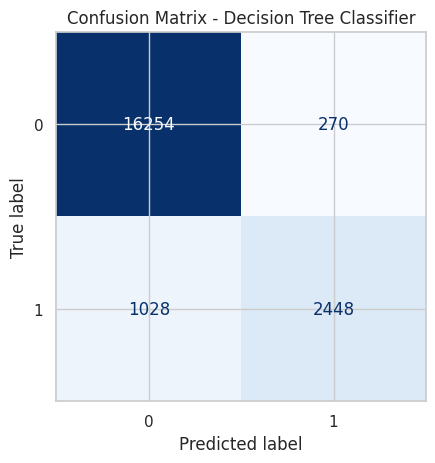

In [14]:
# Visualize Confusion Matrix for Decision Tree Classifier
plt.figure(figsize=(6,6))
ConfusionMatrixDisplay.from_estimator(tree_c, X_test_c, y_test_c, cmap='Blues', colorbar=False)
plt.title("Confusion Matrix - Decision Tree Classifier")
plt.show()

In [15]:
# 11_random_forest_classifier.py
rf_c = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=1)
rf_c.fit(X_train_c, y_train_c)
y_pred_rf = rf_c.predict(X_test_c)
print("Random Forest Accuracy:", accuracy_score(y_test_c, y_pred_rf))


Random Forest Accuracy: 0.8262


<Figure size 600x600 with 0 Axes>

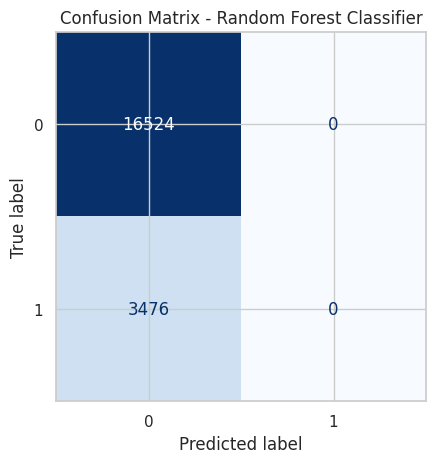

In [16]:
# Visualize Confusion Matrix for Random Forest Classifier
plt.figure(figsize=(6,6))
ConfusionMatrixDisplay.from_estimator(rf_c, X_test_c, y_test_c, cmap='Blues', colorbar=False)
plt.title("Confusion Matrix - Random Forest Classifier")
plt.show()

In [17]:
# 12_classification_report.py
print("Confusion Matrix:\n", confusion_matrix(y_test_c, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test_c, y_pred_rf))


Confusion Matrix:
 [[16524     0]
 [ 3476     0]]

Classification Report:
               precision    recall  f1-score   support

           0       0.83      1.00      0.90     16524
           1       0.00      0.00      0.00      3476

    accuracy                           0.83     20000
   macro avg       0.41      0.50      0.45     20000
weighted avg       0.68      0.83      0.75     20000



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


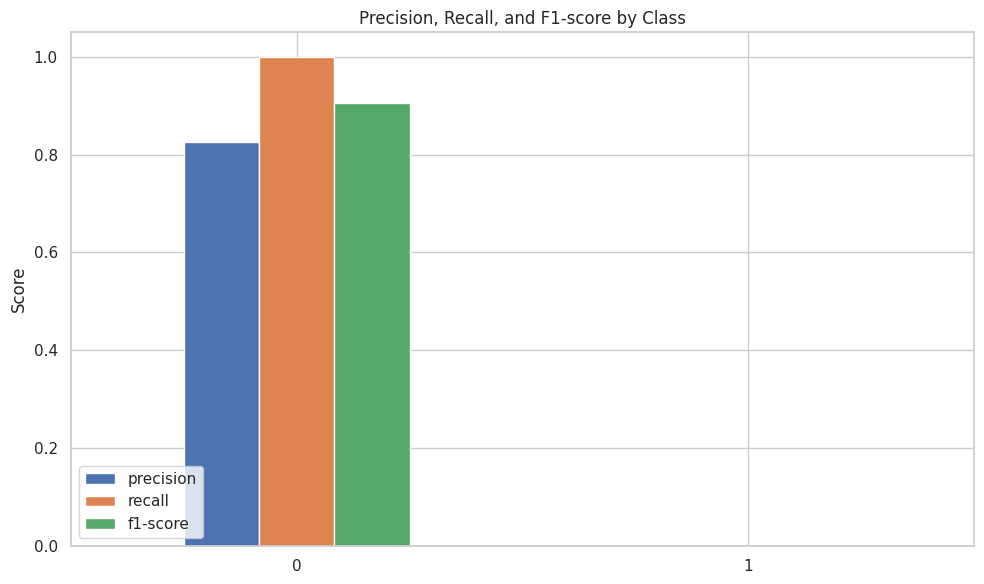

In [18]:
# Visualize Classification Report Metrics
report = classification_report(y_test_c, y_pred_rf, output_dict=True)
df_report = pd.DataFrame(report).transpose()

# Select only the rows for class 0 and 1
df_report = df_report.loc[['0', '1']]

plt.figure(figsize=(10, 6))
df_report[['precision', 'recall', 'f1-score']].plot(kind='bar', ax=plt.gca())
plt.title('Precision, Recall, and F1-score by Class')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

Linear Regression RMSE: 265.1349599444634
R²: 0.9022685046959982


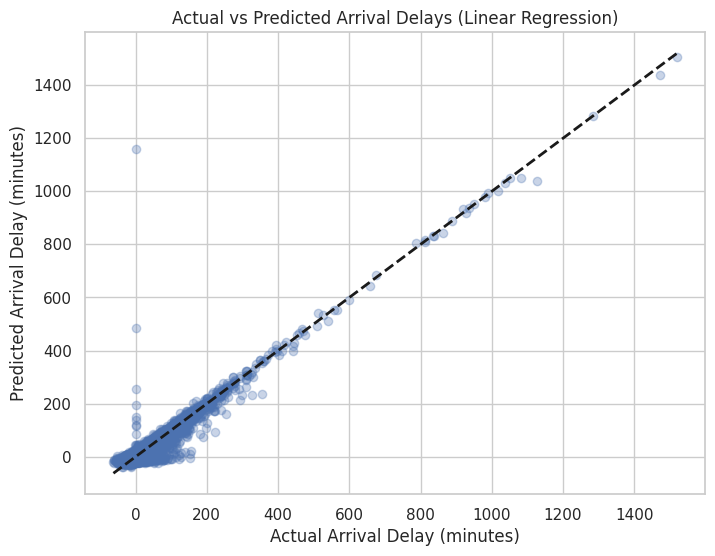

In [19]:
# 13_linear_regression.py
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt # Import matplotlib

# Create a pipeline with an imputer and the linear regression model
lin_reg = Pipeline([
    ('imputer', SimpleImputer(strategy='median')), # Impute missing values with the median
    ('linear_regression', LinearRegression())
])

lin_reg.fit(X_train_r, y_train_r)
y_pred_lin = lin_reg.predict(X_test_r)
print("Linear Regression RMSE:", mean_squared_error(y_test_r, y_pred_lin))
print("R²:", r2_score(y_test_r, y_pred_lin))

# Visualize predicted vs actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test_r, y_pred_lin, alpha=0.3)
plt.xlabel("Actual Arrival Delay (minutes)")
plt.ylabel("Predicted Arrival Delay (minutes)")
plt.title("Actual vs Predicted Arrival Delays (Linear Regression)")
plt.plot([y_test_r.min(), y_test_r.max()], [y_test_r.min(), y_test_r.max()], 'k--', lw=2) # Add a diagonal line
plt.grid(True)
plt.show()

Decision Tree RMSE: 281.67665490233514
R²: 0.8961710644209243


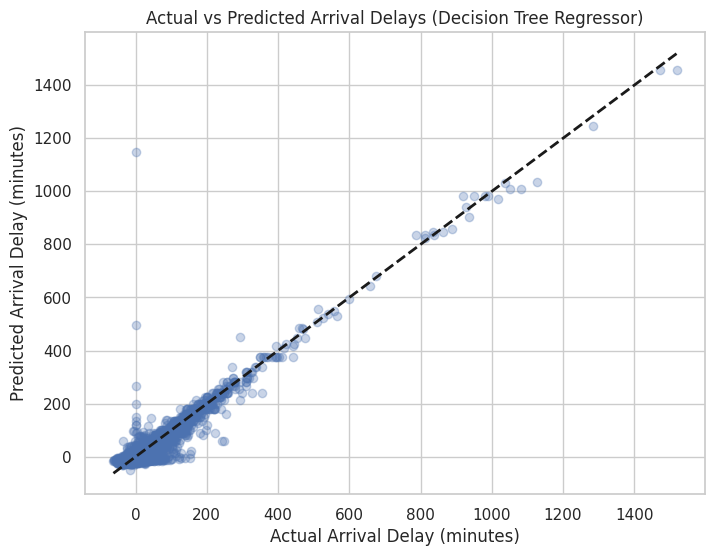

In [20]:
# 14_decision_tree_regressor.py
tree_r = DecisionTreeRegressor(max_depth=10, random_state=1)
tree_r.fit(X_train_r, y_train_r)
y_pred_tree_r = tree_r.predict(X_test_r)
print("Decision Tree RMSE:", mean_squared_error(y_test_r, y_pred_tree_r))
print("R²:", r2_score(y_test_r, y_pred_tree_r))

# Visualize predicted vs actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test_r, y_pred_tree_r, alpha=0.3)
plt.xlabel("Actual Arrival Delay (minutes)")
plt.ylabel("Predicted Arrival Delay (minutes)")
plt.title("Actual vs Predicted Arrival Delays (Decision Tree Regressor)")
plt.plot([y_test_r.min(), y_test_r.max()], [y_test_r.min(), y_test_r.max()], 'k--', lw=2) # Add a diagonal line
plt.grid(True)
plt.show()

Random Forest RMSE: 270.43035673580243
R²: 0.9003165665330566


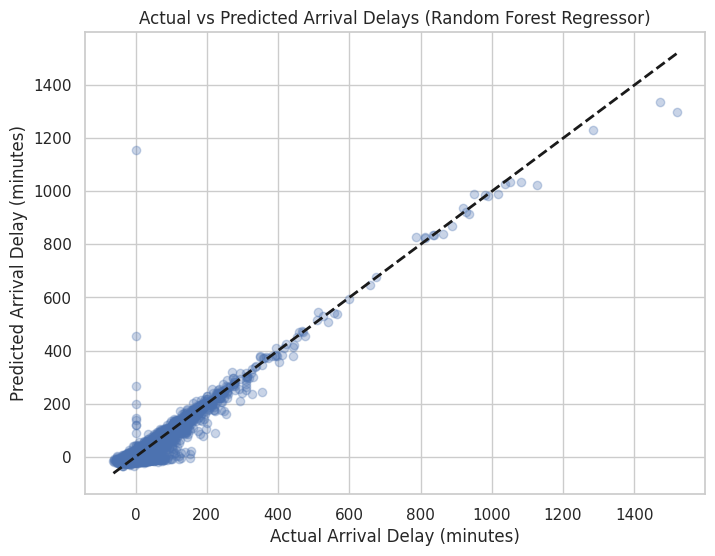

In [21]:
# 15_random_forest_regressor.py
rf_r = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=1)
rf_r.fit(X_train_r, y_train_r)
y_pred_rf_r = rf_r.predict(X_test_r)
print("Random Forest RMSE:", mean_squared_error(y_test_r, y_pred_rf_r))
print("R²:", r2_score(y_test_r, y_pred_rf_r))

# Visualize predicted vs actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test_r, y_pred_rf_r, alpha=0.3)
plt.xlabel("Actual Arrival Delay (minutes)")
plt.ylabel("Predicted Arrival Delay (minutes)")
plt.title("Actual vs Predicted Arrival Delays (Random Forest Regressor)")
plt.plot([y_test_r.min(), y_test_r.max()], [y_test_r.min(), y_test_r.max()], 'k--', lw=2) # Add a diagonal line
plt.grid(True)
plt.show()

In [22]:
# 16_log_reg_coeffs.py
coeffs = pd.Series(log_reg.named_steps['logistic_regression'].coef_[0], index=X_train_c.columns)
print(coeffs.sort_values(ascending=False).head(10))

ORIGIN_AZA    0.874331
DEST_EYW      0.680092
DEST_OGG      0.665002
DEST_PIE      0.630915
DEST_PNS      0.626015
ORIGIN_BIL    0.583842
DEST_BOI      0.580385
ORIGIN_MOB    0.573827
DEST_ASE      0.564234
DEST_MSO      0.562445
dtype: float64


In [23]:
# 17_rf_class_feature_importance.py
importances_c = pd.Series(rf_c.feature_importances_, index=X_train_c.columns)
print(importances_c.sort_values(ascending=False).head(10))


DEP_DELAY      0.688607
hour           0.100267
month          0.036495
day_of_week    0.022092
DISTANCE       0.018486
DEST_ATL       0.006878
DEST_EWR       0.005983
ORIGIN_DEN     0.004133
ORIGIN_DFW     0.003622
ORIGIN_EWR     0.003619
dtype: float64


In [24]:
# 18_rf_reg_feature_importance.py
importances_r = pd.Series(rf_r.feature_importances_, index=X_train_r.columns)
print(importances_r.sort_values(ascending=False).head(10))


DEP_DELAY      0.987512
DISTANCE       0.001277
ORIGIN_MHT     0.000819
hour           0.000723
month          0.000541
day_of_week    0.000463
DEST_MIA       0.000418
DEST_CHS       0.000279
DEST_LGA       0.000259
DEST_ACK       0.000218
dtype: float64


<Figure size 600x600 with 0 Axes>

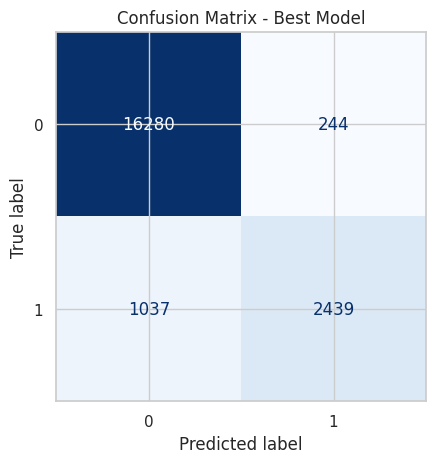

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [25]:
# Confusion Matrix
best_model = log_reg
X_test = X_test_c
y_test = y_test_c
feature_names = X_test.columns

plt.figure(figsize=(6,6))
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test, cmap='Blues', colorbar=False)
plt.title("Confusion Matrix - Best Model")
plt.show()
display(plt.gcf())

<Figure size 600x600 with 0 Axes>

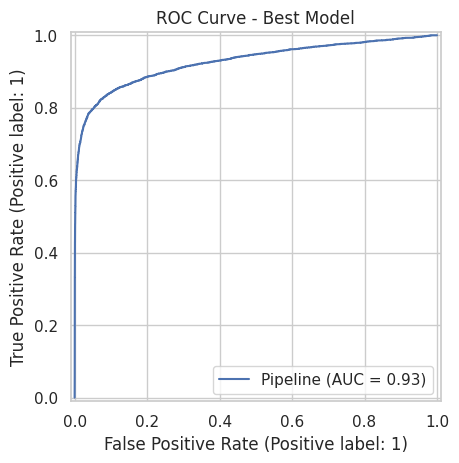

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [26]:
# ROC Curve
plt.figure(figsize=(6,6))
RocCurveDisplay.from_estimator(best_model, X_test, y_test)
plt.title("ROC Curve - Best Model")
plt.show()
display(plt.gcf())

<Figure size 600x600 with 0 Axes>

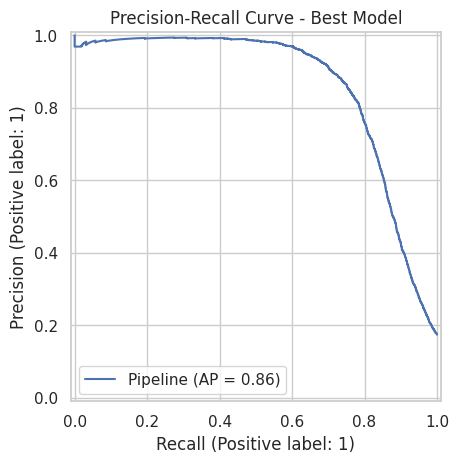

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [27]:
# Precision-Recall Curve
plt.figure(figsize=(6,6))
PrecisionRecallDisplay.from_estimator(best_model, X_test, y_test)
plt.title("Precision-Recall Curve - Best Model")
plt.show()
display(plt.gcf())

In [28]:
# Feature Importances
if hasattr(best_model, "feature_importances_"):
    importances = best_model.feature_importances_
    indices = np.argsort(importances)[-20:]  # top 20
    plt.figure(figsize=(8,6))
    plt.barh(range(len(indices)), importances[indices], align='center')
    plt.yticks(range(len(indices)), np.array(feature_names)[indices])
    plt.title("Top 20 Feature Importances")
    plt.xlabel("Importance Score")
    plt.tight_layout()
    plt.show()
    display(plt.gcf())

In [29]:
# Logistic Regression Coefficients
if hasattr(best_model, "coef_"):
    coefs = best_model.coef_[0]
    indices = np.argsort(coefs)[-20:]
    plt.figure(figsize=(8,6))
    plt.barh(range(len(indices)), coefs[indices], align='center')
    plt.yticks(range(len(indices)), np.array(feature_names)[indices])
    plt.title("Top 20 Positive Coefficients (Logistic Regression)")
    plt.xlabel("Coefficient Value")
    plt.tight_layout()
    plt.show()
    display(plt.gcf())

In [30]:
# Derived features: route (ORIGIN->DEST), month, dow, hour
data['FLIGHT_DATE'] = pd.to_datetime(data.get('FL_DATE', data.get('FLIGHT_DATE', pd.NaT)))
data['MONTH'] = data['FLIGHT_DATE'].dt.month
data['DOW'] = data['FLIGHT_DATE'].dt.day_name()
# use scheduled departure/arrival times if present or actual times
if 'CRS_DEP_TIME' in data.columns:
    # Create HOUR from scheduled dep time (CRS_DEP_TIME often like 730, 2359)
    def time_to_hour(x):
        try:
            x = int(x)
            return x // 100
        except:
            return np.nan
    data['DEP_HOUR'] = data['CRS_DEP_TIME'].apply(time_to_hour)
else:
    data['DEP_HOUR'] = pd.to_datetime(data.get('CRS_DEP_TIME', pd.NaT), errors='coerce').dt.hour
# route
data['ROUTE'] = data['ORIGIN'].astype(str) + '→' + data['DEST'].astype(str)
data[['FLIGHT_DATE','MONTH','DOW','DEP_HOUR','ROUTE']].head()


FLIGHT_DATE  MONTH        DOW  DEP_HOUR    ROUTE
0  2019-02-15      2     Friday        17  ABE→ATL
1  2019-04-15      4     Monday        17  ABE→ATL
2  2019-07-29      7     Monday         6  ABE→ATL
3  2019-10-14     10     Monday        13  ABE→ATL
4  2020-02-05      2  Wednesday        17  ABE→ATL

In [31]:
# Route aggregations
route_stats = data.groupby('ROUTE').agg(
    flights=('ROUTE','size'),
    avg_arr_delay=('ARR_DELAY','mean'),
    med_arr_delay=('ARR_DELAY','median'),
    avg_dep_delay=('DEP_DELAY','mean'),
    total_delay_minutes=('ARR_DELAY', lambda x: np.nansum(x.clip(lower=0))),
).reset_index().sort_values('flights', ascending=False)

route_stats.head(12)


ROUTE  flights  avg_arr_delay  med_arr_delay  avg_dep_delay  \
3272  LAX→SFO      206      -0.665049          -10.0       6.567961   
5657  SFO→LAX      188       1.505319          -10.0      10.803191   
1372  DCA→BOS      159       2.163522           -7.0       6.257862   
2991  JFK→LAX      156       0.134615          -10.0      13.358974   
3231  LAX→LAS      156       7.506410           -5.0      11.647436   
4216  OGG→HNL      152       2.532895           -3.0       3.118421   
4415  ORD→LGA      149      10.597316           -4.0      15.489933   
3123  LAS→LAX      148       1.540541           -2.5       6.148649   
3229  LAX→JFK      147       3.564626           -8.0      13.687075   
3386  LGA→ORD      145       5.420690          -12.0      18.606897   
2483  HNL→OGG      142       1.190141           -3.0       2.239437   
1591  DEN→PHX      133       6.090226           -4.0      13.466166   

      total_delay_minutes  
3272               2102.0  
5657               2319.0  
1372               1844.0  
2991               2270.0  
3231               2303.0  
4216               1165.0  
4415               2844.0  
3123               1286.0  
3229               2349.0  
3386               2805.0  
2483                803.0  
1591               1755.0

/tmp/ipython-input-116661858.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top10_routes, x='flights', y='ROUTE', palette='viridis')


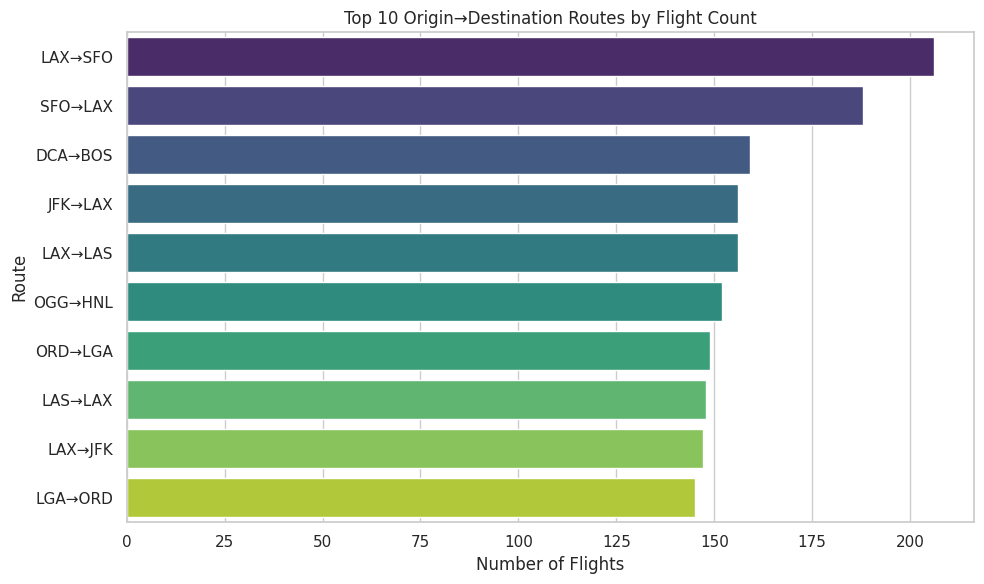

In [32]:
# Top 10 routes by flights (matplotlib)
top10_routes = route_stats.nlargest(10, 'flights')
plt.figure(figsize=(10,6))
sns.barplot(data=top10_routes, x='flights', y='ROUTE', palette='viridis')
plt.title("Top 10 Origin→Destination Routes by Flight Count")
plt.xlabel("Number of Flights")
plt.ylabel("Route")
plt.tight_layout()


In [33]:
# Top 10 routes by total delay minutes (plotly)
top10_delays = route_stats.nlargest(10, 'total_delay_minutes')
fig = px.bar(top10_delays, x='total_delay_minutes', y='ROUTE', orientation='h',
             title="Top 10 Routes by Total Arrival Delay Minutes",
             labels={'total_delay_minutes':'Total Delay Minutes','ROUTE':'Route'})
fig.update_layout(height=480)
fig.show()


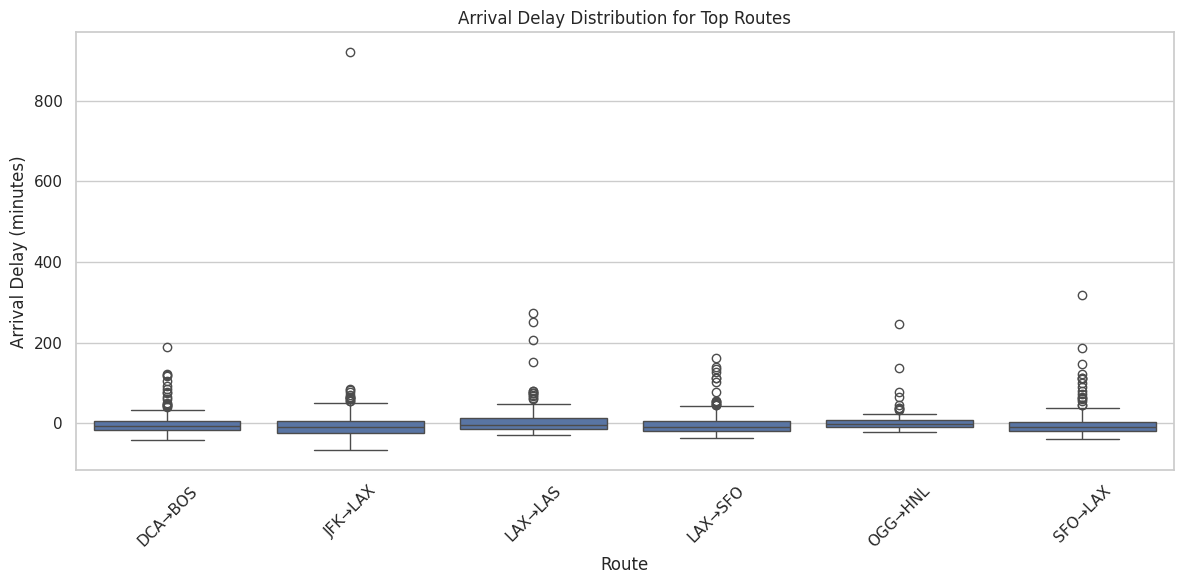

In [34]:
# Boxplot showing ARR_DELAY distribution for top 6 routes
top_routes_list = top10_routes['ROUTE'].tolist()[:6]
subset = data[data['ROUTE'].isin(top_routes_list)].copy()
plt.figure(figsize=(12,6))
sns.boxplot(data=subset, x='ROUTE', y='ARR_DELAY')
plt.title('Arrival Delay Distribution for Top Routes')
plt.xlabel('Route')
plt.ylabel('Arrival Delay (minutes)')
plt.xticks(rotation=45)
plt.tight_layout()


/tmp/ipython-input-634258506.py:6: FutureWarning:

The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior



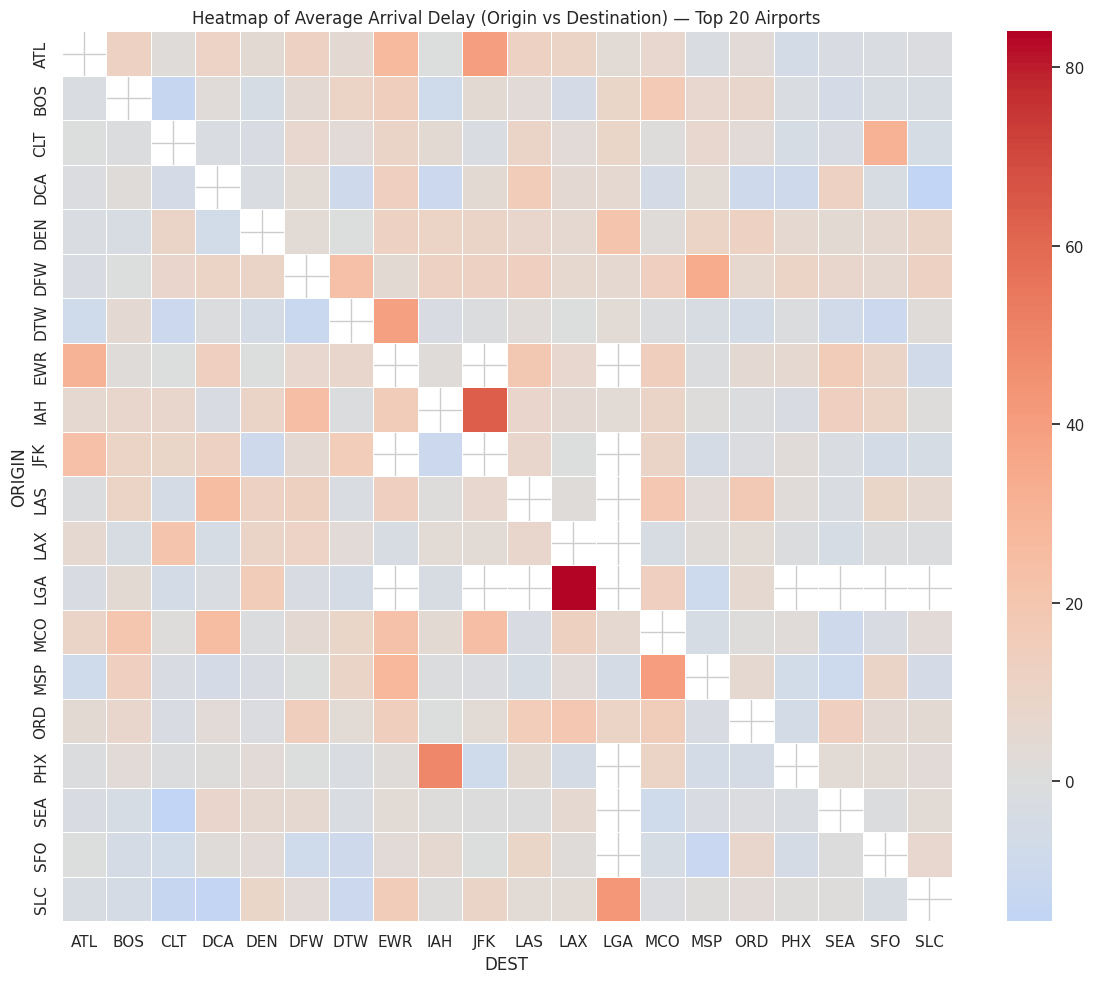

In [35]:
# Pivot table: origin x dest average arrival delay (sample top airports)
# Limit to top 20 busiest airports by number of departures/arrivals for readability
airport_counts = pd.concat([data['ORIGIN'], data['DEST']]).value_counts()
top_airports = airport_counts.nlargest(20).index.tolist()
sub = data[data['ORIGIN'].isin(top_airports) & data['DEST'].isin(top_airports)]
pivot = sub.pivot_table(index='ORIGIN', columns='DEST', values='ARR_DELAY', aggfunc='mean')
plt.figure(figsize=(12,10))
sns.heatmap(pivot, cmap='coolwarm', center=0, linewidths=.5)
plt.title('Heatmap of Average Arrival Delay (Origin vs Destination) — Top 20 Airports')
plt.tight_layout()


/tmp/ipython-input-1195249765.py:2: FutureWarning:

The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior



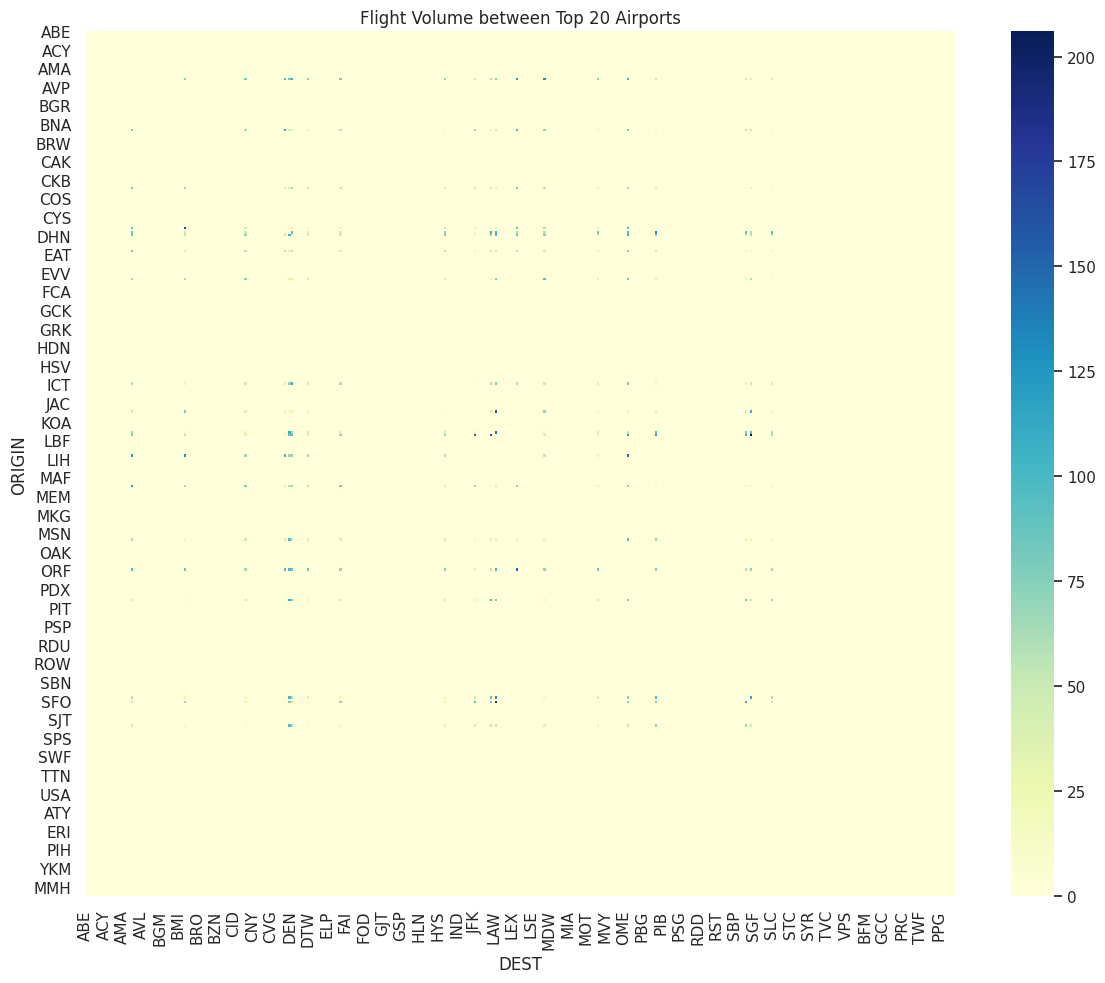

In [36]:
# Heatmap of counts between top airports
pivot_counts = sub.pivot_table(index='ORIGIN', columns='DEST', values='ROUTE', aggfunc='count').fillna(0)
plt.figure(figsize=(12,10))
sns.heatmap(pivot_counts, cmap='YlGnBu', annot=False)
plt.title('Flight Volume between Top 20 Airports')
plt.tight_layout()


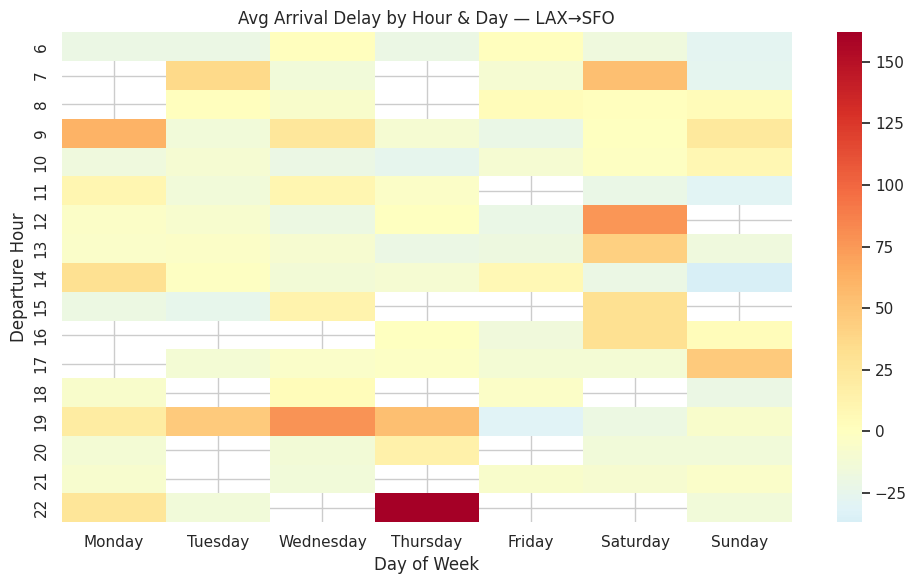

In [37]:
# Time-of-day vs day-of-week average arr_delay for one top route
route_example = top10_routes['ROUTE'].iloc[0]
rdata = data[data['ROUTE'] == route_example].copy()
pivot_td = rdata.pivot_table(index='DEP_HOUR', columns='DOW', values='ARR_DELAY', aggfunc='mean')
# Reorder days to Mon..Sun if present
days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
pivot_td = pivot_td.reindex(columns=[d for d in days if d in pivot_td.columns])
plt.figure(figsize=(10,6))
sns.heatmap(pivot_td, cmap='RdYlBu_r', center=0)
plt.title(f'Avg Arrival Delay by Hour & Day — {route_example}')
plt.xlabel('Day of Week')
plt.ylabel('Departure Hour')
plt.tight_layout()


In [38]:
# Airport-level summary: total flights, avg arr delay, avg dep delay
origin_stats = data.groupby('ORIGIN').agg(
    departures=('ORIGIN','size'),
    avg_dep_delay=('DEP_DELAY','mean'),
).reset_index().rename(columns={'ORIGIN':'IATA'})
dest_stats = data.groupby('DEST').agg(
    arrivals=('DEST','size'),
    avg_arr_delay=('ARR_DELAY','mean'),
).reset_index().rename(columns={'DEST':'IATA'})

airport_stats = pd.merge(origin_stats, dest_stats, on='IATA', how='outer').fillna(0)
airport_stats['total_ops'] = airport_stats['departures'] + airport_stats['arrivals']
airport_stats = airport_stats.sort_values('total_ops', ascending=False)
airport_stats.head(10)


/tmp/ipython-input-3647638803.py:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipython-input-3647638803.py:6: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



IATA  departures  avg_dep_delay  arrivals  avg_arr_delay  total_ops
23   ATL      5099.0       8.583055    5095.0       0.024926    10194.0
100  DFW      4444.0      12.509001    4239.0       9.931587     8683.0
259  ORD      4053.0      10.103873    4157.0       4.561703     8210.0
99   DEN      3886.0      12.938240    3956.0       4.670627     7842.0
77   CLT      3110.0       9.836334    3269.0       2.031202     6379.0
199  LAX      2866.0       8.921494    2804.0       3.507489     5670.0
274  PHX      2460.0       9.453252    2628.0       0.878995     5088.0
197  LAS      2391.0      11.548724    2413.0       5.887691     4804.0
321  SEA      2451.0       6.093023    2323.0       1.712871     4774.0
221  MCO      2148.0      15.774674    2171.0       8.146937     4319.0

In [39]:
# Mapping of top airports (requires airport lat/lon data in input file)
airports_file = "/mnt/data/airports.csv"
if os.path.exists(airports_file):
    ap = pd.read_csv(airports_file)
    ap = ap.rename(columns={'iata_code':'IATA','latitude':'lat','longitude':'lon'})
    merged = pd.merge(airport_stats, ap[['IATA','lat','lon']], on='IATA', how='left')
else:
    # Fallback removed - input data must contain lat/lon for this plot
    merged = airport_stats.copy()
    merged['lat'] = np.nan
    merged['lon'] = np.nan
    print("Warning: Airports file not found. Plotting requires airport latitude and longitude data.")

# Display the merged data to show missing lat/lon
print("Data used for plotting:")
display(merged.head())

# Choose top 30 airports for mapping
top_map = merged.nlargest(30, 'total_ops').copy()

# Drop rows where lat or lon is NaN to avoid errors in plotting
top_map.dropna(subset=['lat', 'lon'], inplace=True)

if not top_map.empty:
    fig = px.scatter_geo(top_map, lat='lat', lon='lon', hover_name='IATA', size='total_ops',
                         title='Top 30 Airports by Total Operations (size -> total_ops)',
                         projection='natural earth')
    fig.update_traces(marker=dict(line_width=0))
    fig.show()
else:
    print("No airport data with latitude and longitude available for plotting.")

Data used for plotting:


IATA  departures  avg_dep_delay  arrivals  avg_arr_delay  total_ops  lat  \
23   ATL      5099.0       8.583055    5095.0       0.024926    10194.0  NaN   
100  DFW      4444.0      12.509001    4239.0       9.931587     8683.0  NaN   
259  ORD      4053.0      10.103873    4157.0       4.561703     8210.0  NaN   
99   DEN      3886.0      12.938240    3956.0       4.670627     7842.0  NaN   
77   CLT      3110.0       9.836334    3269.0       2.031202     6379.0  NaN   

     lon  
23   NaN  
100  NaN  
259  NaN  
99   NaN  
77   NaN

No airport data with latitude and longitude available for plotting.


In [41]:
# Plot flows for top N routes as lines on map (requires lat/lon for origin & dest)
# Build origin/dest coords dataframe
if 'ap' in locals() and not ap.empty:
    coords = ap[['IATA','lat','lon']].drop_duplicates()
else:
    # attempt to get coords from earlier coords
    coords = merged[['IATA','lat','lon']].drop_duplicates()

# Prepare top N routes
topN = route_stats.nlargest(10, 'flights').copy()
topN[['ORIGIN','DEST']] = topN['ROUTE'].str.split('→', expand=True)
topN = pd.merge(topN, coords.rename(columns={'IATA':'ORIGIN','lat':'olat','lon':'olon'}), on='ORIGIN', how='left')
topN = pd.merge(topN, coords.rename(columns={'IATA':'DEST','lat':'dlat','lon':'dlon'}), on='DEST', how='left')

# Check if coordinate data is available for plotting
if topN[['olat', 'olon', 'dlat', 'dlon']].isnull().values.any():
    print("Warning: Missing latitude or longitude data for some routes. Plot may be incomplete or empty.")
    print("Data used for plotting routes:")
    display(topN)

fig = go.Figure()
# add airport nodes
for _, r in topN.iterrows():
    if pd.notna(r['olat']):
        fig.add_trace(go.Scattergeo(
            lon=[r['olon']], lat=[r['olat']],
            mode='markers+text', text=r['ORIGIN'], textposition="top center",
            marker=dict(size=6)
        ))
    if pd.notna(r['dlat']):
        fig.add_trace(go.Scattergeo(
            lon=[r['dlon']], lat=[r['dlat']],
            mode='markers+text', text=r['DEST'], textposition="top center",
            marker=dict(size=6)
        ))
# add lines
for _, r in topN.iterrows():
    if pd.notna(r['olon']) and pd.notna(r['dlon']):
        fig.add_trace(go.Scattergeo(
            lon=[r['olon'], r['dlon']],
            lat=[r['olat'], r['dlat']],
            mode='lines',
            line=dict(width=1 + np.log1p(r['flights']/50), color='blue'),
            hoverinfo='text',
            text=f"{r['ROUTE']}<br>flights={r['flights']}<br>avg_arr_delay={r['avg_arr_delay']:.1f}"
        ))
fig.update_layout(title_text='Top Route Flows (Top 10) — flight volumes shown as line width', showlegend=False,
                  geo=dict(scope='usa' if coords['lon'].between(-170,-50).any() else 'world'))
fig.show()

Data used for plotting routes:


ROUTE  flights  avg_arr_delay  med_arr_delay  avg_dep_delay  \
0  LAX→SFO      206      -0.665049          -10.0       6.567961   
1  SFO→LAX      188       1.505319          -10.0      10.803191   
2  DCA→BOS      159       2.163522           -7.0       6.257862   
3  JFK→LAX      156       0.134615          -10.0      13.358974   
4  LAX→LAS      156       7.506410           -5.0      11.647436   
5  OGG→HNL      152       2.532895           -3.0       3.118421   
6  ORD→LGA      149      10.597316           -4.0      15.489933   
7  LAS→LAX      148       1.540541           -2.5       6.148649   
8  LAX→JFK      147       3.564626           -8.0      13.687075   
9  LGA→ORD      145       5.420690          -12.0      18.606897   

   total_delay_minutes ORIGIN DEST  olat  olon  dlat  dlon  
0               2102.0    LAX  SFO   NaN   NaN   NaN   NaN  
1               2319.0    SFO  LAX   NaN   NaN   NaN   NaN  
2               1844.0    DCA  BOS   NaN   NaN   NaN   NaN  
3               2270.0    JFK  LAX   NaN   NaN   NaN   NaN  
4               2303.0    LAX  LAS   NaN   NaN   NaN   NaN  
5               1165.0    OGG  HNL   NaN   NaN   NaN   NaN  
6               2844.0    ORD  LGA   NaN   NaN   NaN   NaN  
7               1286.0    LAS  LAX   NaN   NaN   NaN   NaN  
8               2349.0    LAX  JFK   NaN   NaN   NaN   NaN  
9               2805.0    LGA  ORD   NaN   NaN   NaN   NaN

In [88]:
# Pie charts
# Distribution of Airlines
airline_counts = data['AIRLINE'].value_counts().reset_index()
airline_counts.columns = ['AIRLINE', 'count']
fig = px.pie(airline_counts, values='count', names='AIRLINE', title='Distribution of Flights by Airline')
fig.show()


In [87]:
# Distribution of Time of Day
time_of_day_counts = data['time_of_day'].value_counts().reset_index()
time_of_day_counts.columns = ['time_of_day', 'count']
fig = px.pie(time_of_day_counts, values='count', names='time_of_day', title='Distribution of Flights by Time of Day')
fig.show()

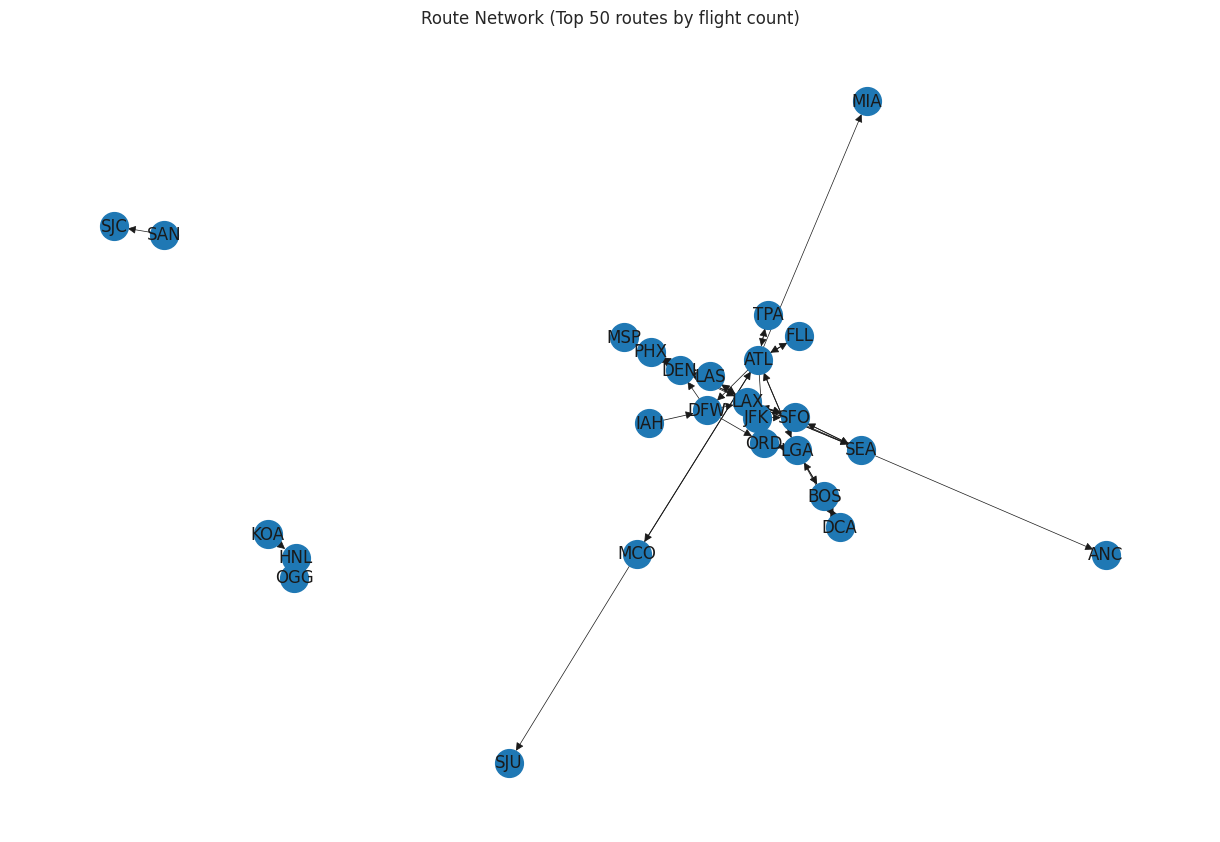

In [43]:
# Create a directed network of top 50 routes
G = nx.DiGraph()
top50 = route_stats.nlargest(50, 'flights').copy()
for _, r in top50.iterrows():
    origin, dest = r['ROUTE'].split('→')
    G.add_edge(origin, dest, weight=int(r['flights']), avg_delay=r['avg_arr_delay'])

plt.figure(figsize=(12,8))
pos = nx.spring_layout(G, k=0.5, iterations=30, seed=7)
weights = [G[u][v]['weight'] for u,v in G.edges()]
nx.draw(G, pos, with_labels=True, node_size=400, width=[max(0.5, w/200) for w in weights], arrowsize=12)
plt.title('Route Network (Top 50 routes by flight count)')
plt.show()


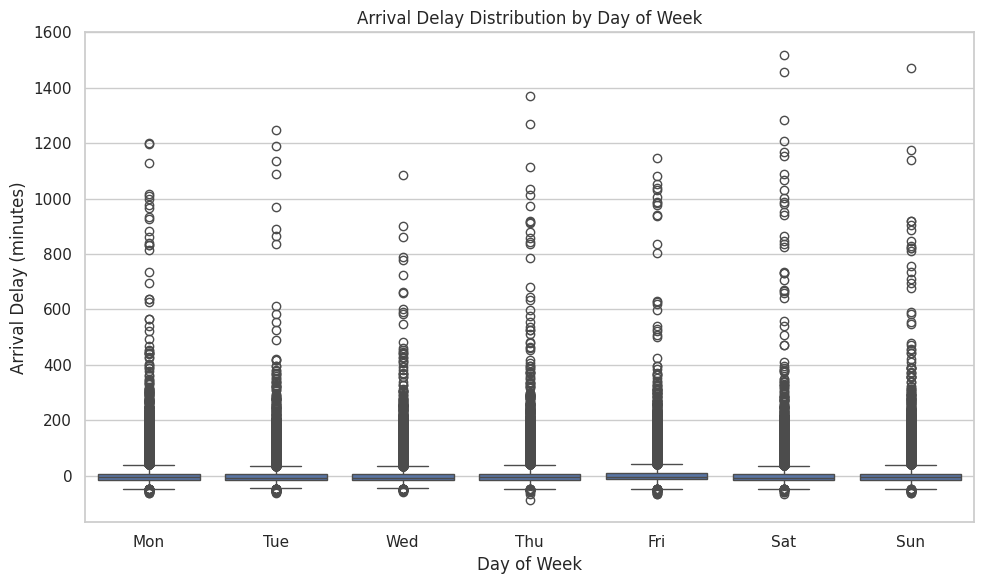

In [95]:
# Box plots
# Arrival delay distribution by day of week
plt.figure(figsize=(10, 6))
sns.boxplot(data=data, x='day_of_week', y='ARR_DELAY')
plt.title('Arrival Delay Distribution by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Arrival Delay (minutes)')
plt.xticks(ticks=[0, 1, 2, 3, 4, 5, 6], labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.tight_layout()
plt.show()



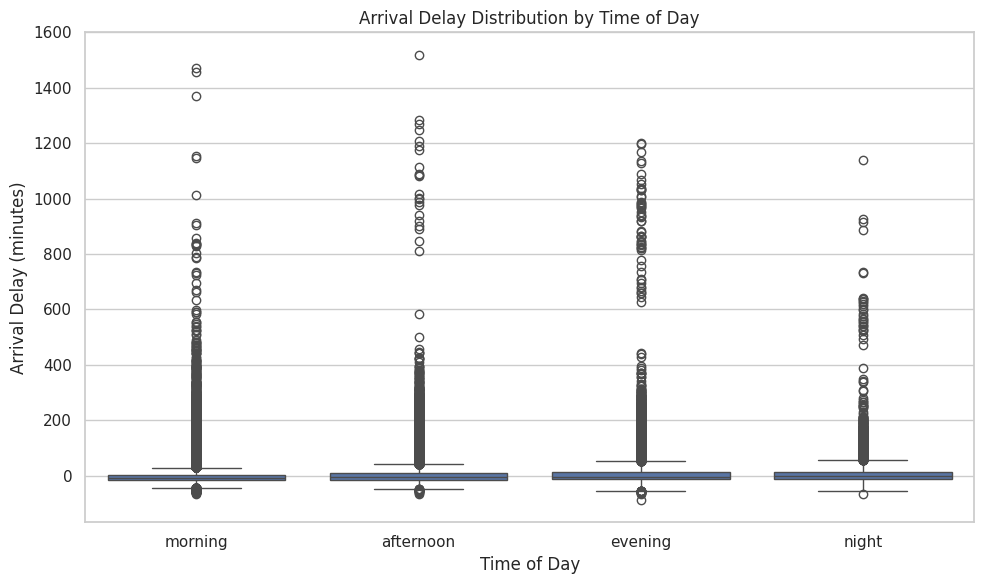

In [96]:
# Arrival delay distribution by time of day
plt.figure(figsize=(10, 6))
sns.boxplot(data=data, x='time_of_day', y='ARR_DELAY', order=['morning', 'afternoon', 'evening', 'night'])
plt.title('Arrival Delay Distribution by Time of Day')
plt.xlabel('Time of Day')
plt.ylabel('Arrival Delay (minutes)')
plt.tight_layout()
plt.show()

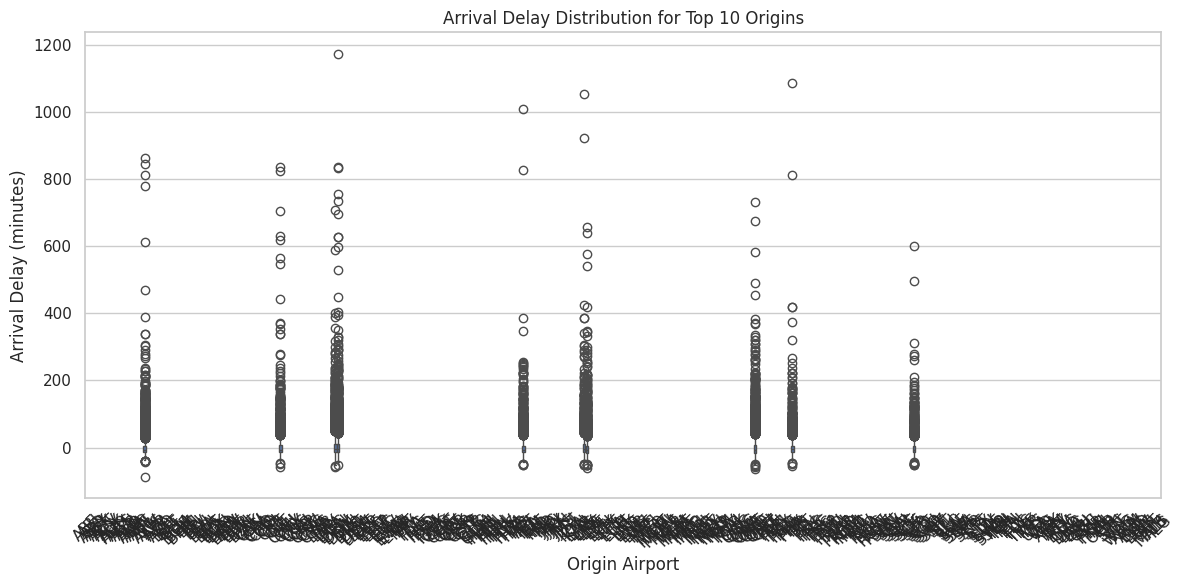

In [97]:
# Arrival delay distribution for top 10 origins
top_origins_list = data['ORIGIN'].value_counts().nlargest(10).index.tolist()
subset_origin = data[data['ORIGIN'].isin(top_origins_list)].copy()
plt.figure(figsize=(12, 6))
sns.boxplot(data=subset_origin, x='ORIGIN', y='ARR_DELAY')
plt.title('Arrival Delay Distribution for Top 10 Origins')
plt.xlabel('Origin Airport')
plt.ylabel('Arrival Delay (minutes)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

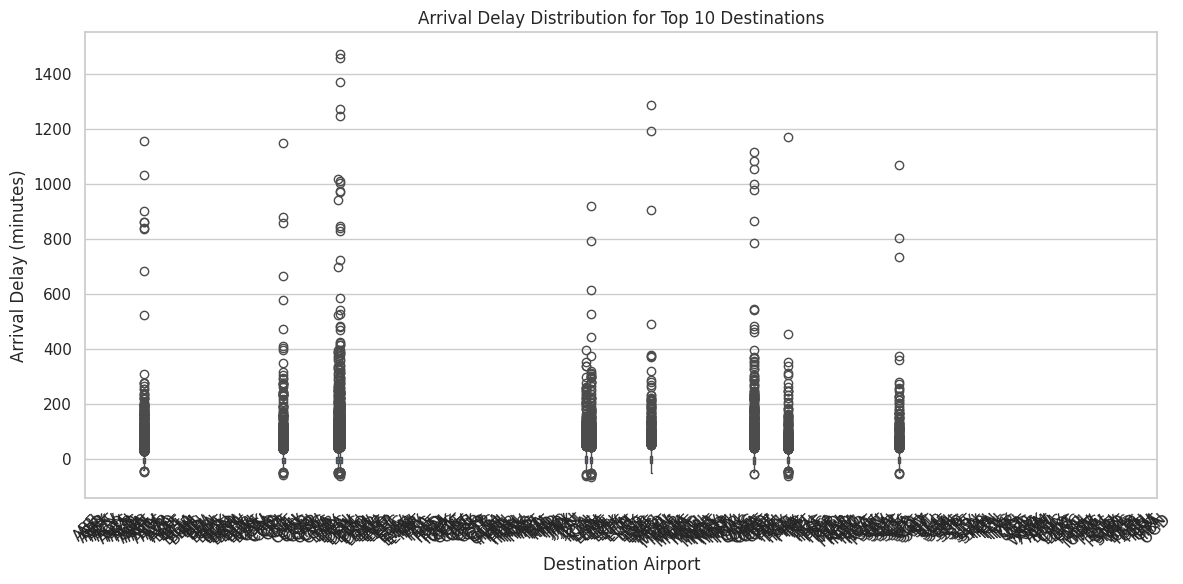

In [98]:
# Arrival delay distribution for top 10 destinations
top_dests_list = data['DEST'].value_counts().nlargest(10).index.tolist()
subset_dest = data[data['DEST'].isin(top_dests_list)].copy()
plt.figure(figsize=(12, 6))
sns.boxplot(data=subset_dest, x='DEST', y='ARR_DELAY')
plt.title('Arrival Delay Distribution for Top 10 Destinations')
plt.xlabel('Destination Airport')
plt.ylabel('Arrival Delay (minutes)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

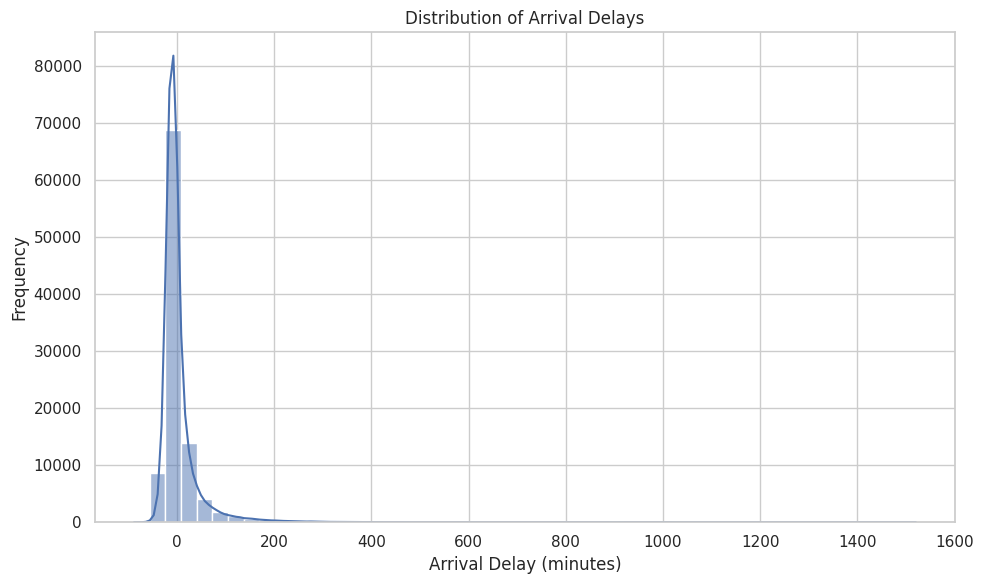

In [99]:
# Histograms
# Distribution of Arrival Delays
plt.figure(figsize=(10, 6))
sns.histplot(data=data, x='ARR_DELAY', bins=50, kde=True)
plt.title('Distribution of Arrival Delays')
plt.xlabel('Arrival Delay (minutes)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


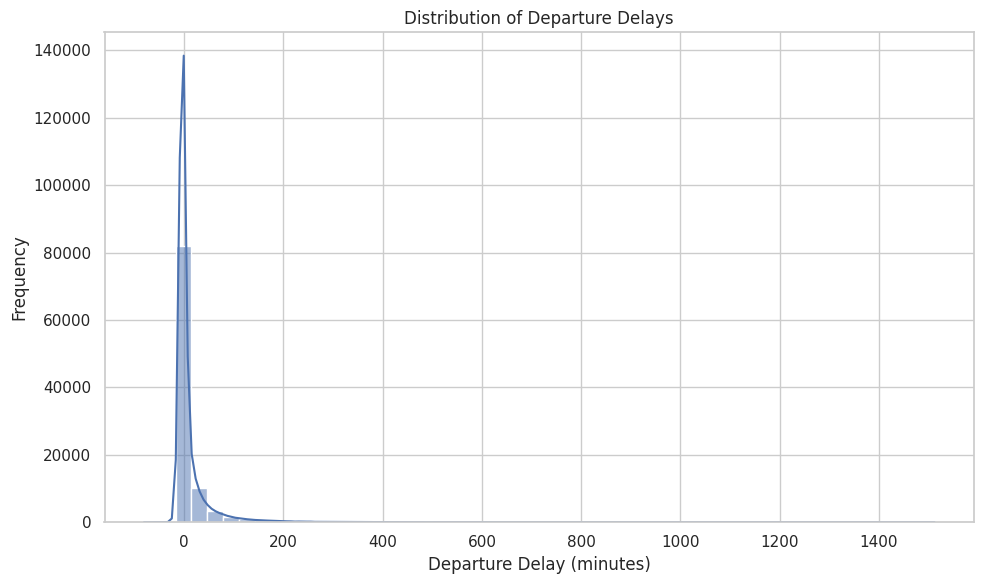

In [100]:
# Distribution of Departure Delays
plt.figure(figsize=(10, 6))
sns.histplot(data=data, x='DEP_DELAY', bins=50, kde=True)
plt.title('Distribution of Departure Delays')
plt.xlabel('Departure Delay (minutes)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

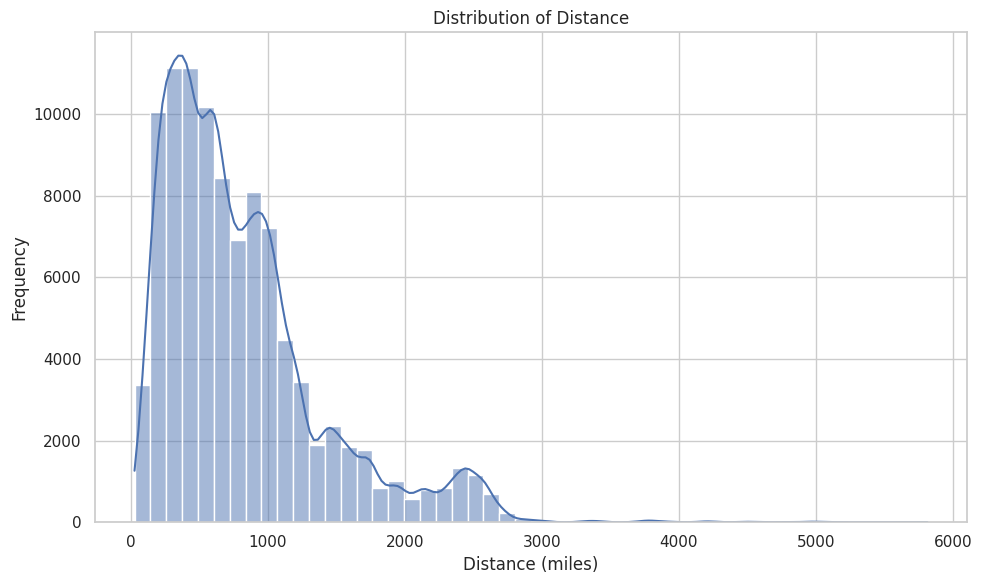

In [101]:
# Distribution of Distance
plt.figure(figsize=(10, 6))
sns.histplot(data=data, x='DISTANCE', bins=50, kde=True)
plt.title('Distribution of Distance')
plt.xlabel('Distance (miles)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [44]:
# Sankey between top origins and top destinations
top_origins = data['ORIGIN'].value_counts().nlargest(8).index.tolist()
top_dests = data['DEST'].value_counts().nlargest(8).index.tolist()
sdata = data[data['ORIGIN'].isin(top_origins) & data['DEST'].isin(top_dests)]
sagg = sdata.groupby(['ORIGIN','DEST']).size().reset_index(name='count')

labels = list(sorted(set(top_origins + top_dests)))
label_index = {l:i for i,l in enumerate(labels)}
source = sagg['ORIGIN'].map(label_index).tolist()
target = sagg['DEST'].map(label_index).tolist()
value = sagg['count'].tolist()

fig = go.Figure(data=[go.Sankey(
    node=dict(label=labels, pad=15, thickness=20),
    link=dict(source=source, target=target, value=value)
)])
fig.update_layout(title_text="Sankey: Flows between Top Origins and Top Destinations", font_size=10)
fig.show()


/tmp/ipython-input-2643899873.py:5: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [45]:
# Build a clean summary table for reporting
summary_cols = ['ROUTE','flights','avg_arr_delay','med_arr_delay','avg_dep_delay','total_delay_minutes']
report_table = route_stats[summary_cols].copy()
report_table['avg_arr_delay'] = report_table['avg_arr_delay'].round(2)
report_table['avg_dep_delay'] = report_table['avg_dep_delay'].round(2)
report_table = report_table.sort_values('flights', ascending=False).reset_index(drop=True)
report_table.head(20)
# In Colab, pandas shows it nicely; use display if needed
from IPython.display import display
display(report_table.head(20))


ROUTE  flights  avg_arr_delay  med_arr_delay  avg_dep_delay  \
0   LAX→SFO      206          -0.67          -10.0       6.570000   
1   SFO→LAX      188           1.51          -10.0      10.800000   
2   DCA→BOS      159           2.16           -7.0       6.260000   
3   LAX→LAS      156           7.51           -5.0      11.650000   
4   JFK→LAX      156           0.13          -10.0      13.360000   
5   OGG→HNL      152           2.53           -3.0       3.120000   
6   ORD→LGA      149          10.60           -4.0      15.490000   
7   LAS→LAX      148           1.54           -2.5       6.150000   
8   LAX→JFK      147           3.56           -8.0      13.690000   
9   LGA→ORD      145           5.42          -12.0      18.610001   
10  HNL→OGG      142           1.19           -3.0       2.240000   
11  DEN→PHX      133           6.09           -4.0      13.470000   
12  SEA→LAX      129           6.04           -6.0      11.440000   
13  FLL→ATL      128           5.99           -6.0      12.090000   
14  ATL→MCO      127           7.03           -6.0      11.060000   
15  LGA→BOS      127           4.53          -10.0      13.710000   
16  LAX→ORD      124           3.86           -8.0      10.100000   
17  LGA→ATL      123          -2.88           -8.0       7.790000   
18  ATL→LGA      121           3.83           -4.0      11.310000   
19  MCO→ATL      119           9.64           -7.0      15.480000   

    total_delay_minutes  
0                2102.0  
1                2319.0  
2                1844.0  
3                2303.0  
4                2270.0  
5                1165.0  
6                2844.0  
7                1286.0  
8                2349.0  
9                2805.0  
10                803.0  
11               1755.0  
12               1775.0  
13               1765.0  
14               1729.0  
15               2193.0  
16               1773.0  
17               1166.0  
18               1395.0  
19               2160.0

/tmp/ipython-input-791702684.py:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




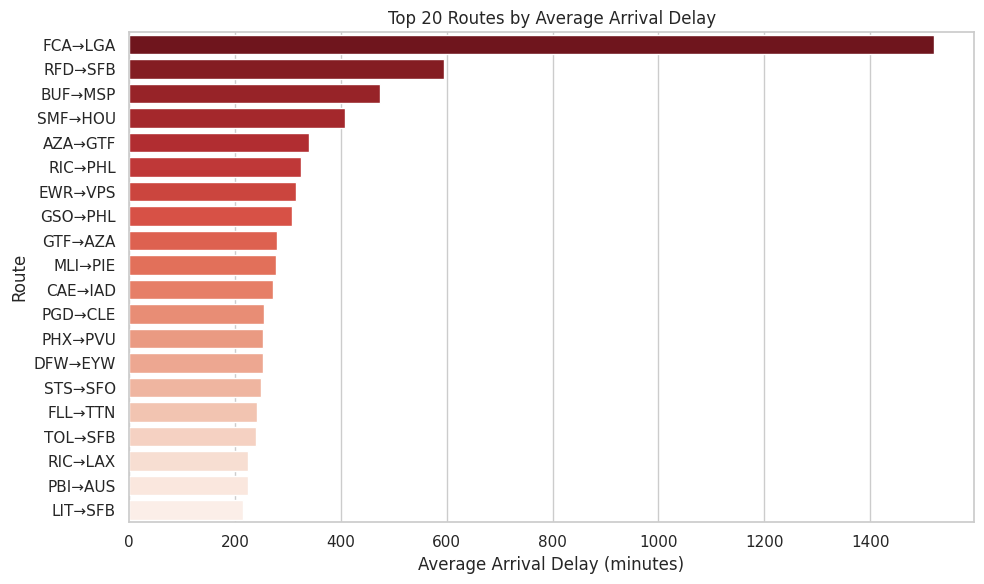

In [46]:
# Top 20 routes ranked by average arrival delay
top20_avg_delay = route_stats.sort_values('avg_arr_delay', ascending=False).head(20)
plt.figure(figsize=(10,6))
sns.barplot(data=top20_avg_delay, x='avg_arr_delay', y='ROUTE', palette='Reds_r')
plt.title('Top 20 Routes by Average Arrival Delay')
plt.xlabel('Average Arrival Delay (minutes)')
plt.ylabel('Route')
plt.tight_layout()


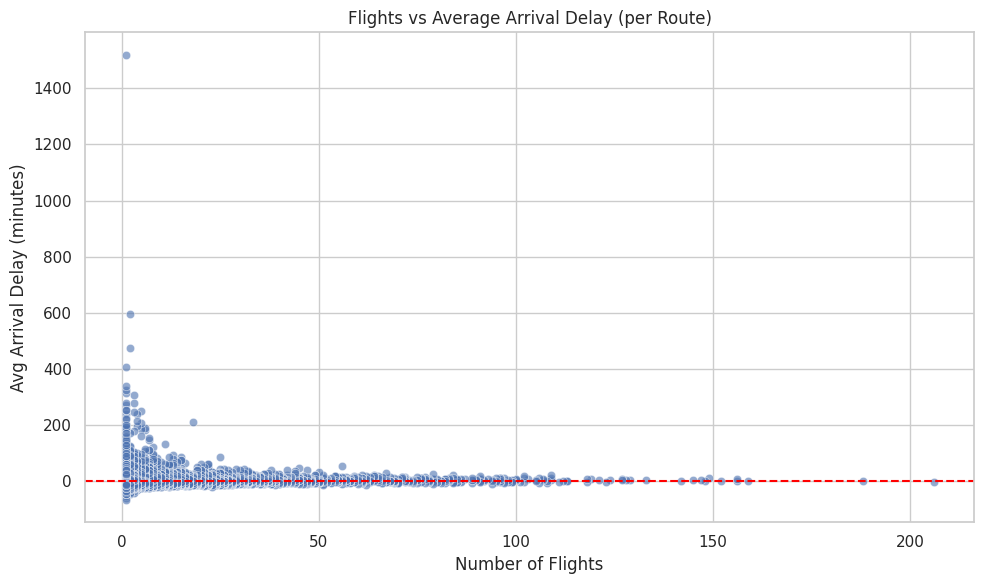

In [47]:
# Scatterplot to detect routes with both high volume and high avg delay
plt.figure(figsize=(10,6))
sns.scatterplot(data=route_stats, x='flights', y='avg_arr_delay', alpha=0.6)
plt.title('Flights vs Average Arrival Delay (per Route)')
plt.xlabel('Number of Flights')
plt.ylabel('Avg Arrival Delay (minutes)')
plt.axhline(0, color='red', linestyle='--')
plt.tight_layout()


In [48]:
# Identify routes with >100 flights and avg_arr_delay > 5 minutes
problem_routes = route_stats[(route_stats['flights'] > 100) & (route_stats['avg_arr_delay'] > 5)]
problem_routes[['ROUTE','flights','avg_arr_delay']].sort_values('avg_arr_delay', ascending=False)

ROUTE  flights  avg_arr_delay
2715  IAH→DFW      109      24.706423
4413  ORD→LAX      102      19.009804
3615  MCO→SJU      102      13.176471
3097  LAS→DEN      106      12.339622
173   ATL→DFW      109      11.477064
4415  ORD→LGA      149      10.597316
1686  DFW→DEN      103       9.864078
3540  MCO→ATL      119       9.638656
185   ATL→FLL      118       8.483051
1550  DEN→LAS      107       7.757010
3231  LAX→LAS      156       7.506410
221   ATL→MCO      127       7.031496
1774  DFW→ORD      105       6.390476
1591  DEN→PHX      133       6.090226
5515  SEA→LAX      129       6.038760
1551  DEN→LAX      107       6.028038
2209  FLL→ATL      128       5.992188
3386  LGA→ORD      145       5.420690

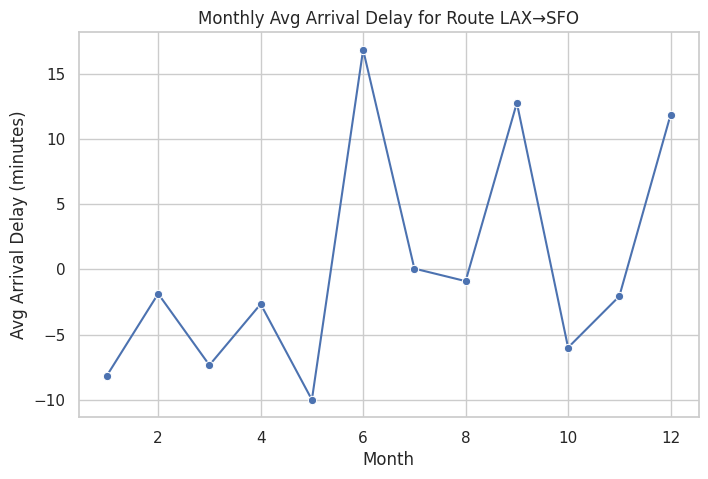

In [49]:
# Delay trend over months for top route
top_route = route_stats['ROUTE'].iloc[0]
rdata = data[data['ROUTE'] == top_route].copy()
monthly_delay = rdata.groupby('MONTH')['ARR_DELAY'].mean().reset_index()
plt.figure(figsize=(8,5))
sns.lineplot(data=monthly_delay, x='MONTH', y='ARR_DELAY', marker='o')
plt.title(f'Monthly Avg Arrival Delay for Route {top_route}')
plt.xlabel('Month'); plt.ylabel('Avg Arrival Delay (minutes)')
plt.grid(True)


In [50]:
# Compare average delays by airline for top route
if 'OP_CARRIER' in data.columns:
    carrier_route = rdata.groupby('OP_CARRIER')['ARR_DELAY'].mean().reset_index().sort_values('ARR_DELAY')
    plt.figure(figsize=(8,5))
    sns.barplot(data=carrier_route, x='ARR_DELAY', y='OP_CARRIER', palette='coolwarm')
    plt.title(f'Avg Arrival Delay by Carrier on Route {top_route}')
    plt.xlabel('Avg Arrival Delay (minutes)'); plt.ylabel('Airline')
    plt.tight_layout()
else:
    print("Carrier column not found.")


Carrier column not found.


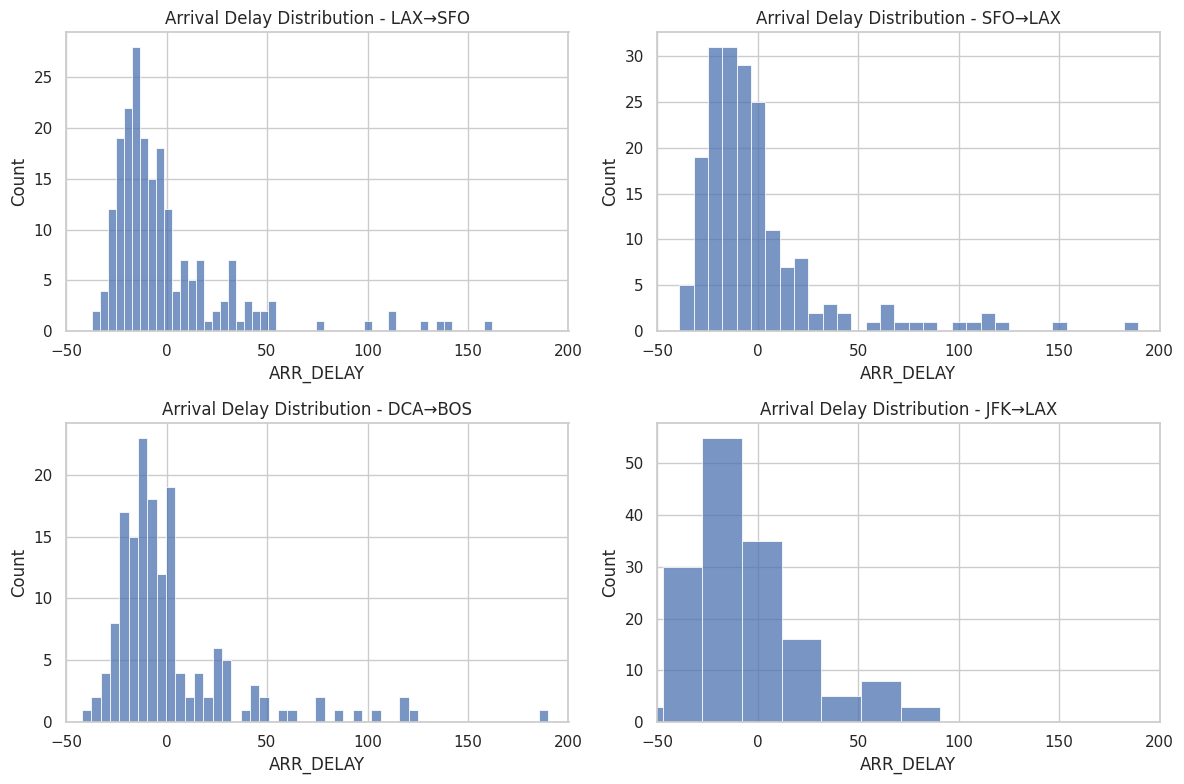

In [51]:
# Plot histograms for top 4 routes
top4_routes = top10_routes['ROUTE'].head(4).tolist()
fig, axes = plt.subplots(2,2, figsize=(12,8))
for i, route in enumerate(top4_routes):
    ax = axes[i//2, i%2]
    sns.histplot(data=data[data['ROUTE']==route], x='ARR_DELAY', bins=50, ax=ax, kde=False)
    ax.set_title(f'Arrival Delay Distribution - {route}')
    ax.set_xlim(-50, 200)
plt.tight_layout()


In [52]:
# Interactive bar: busiest airports (departures + arrivals)
fig = px.bar(airport_stats.head(20), x='IATA', y='total_ops',
             hover_data=['avg_dep_delay','avg_arr_delay'],
             title="Top 20 Busiest Airports by Operations",
             labels={'total_ops':'Total Flights','IATA':'Airport'})
fig.show()


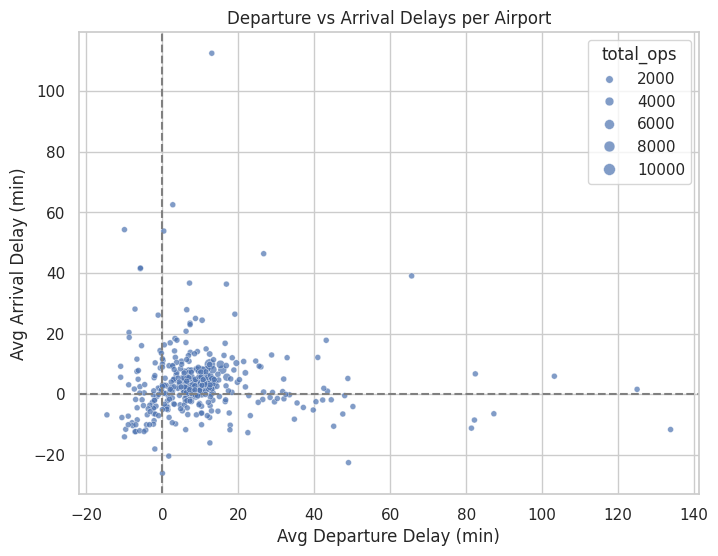

In [53]:
# Scatter correlation between avg departure and avg arrival delay at airports
plt.figure(figsize=(8,6))
sns.scatterplot(data=airport_stats, x='avg_dep_delay', y='avg_arr_delay', size='total_ops', alpha=0.7)
plt.title('Departure vs Arrival Delays per Airport')
plt.xlabel('Avg Departure Delay (min)')
plt.ylabel('Avg Arrival Delay (min)')
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='gray', linestyle='--')


/tmp/ipython-input-4031655705.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




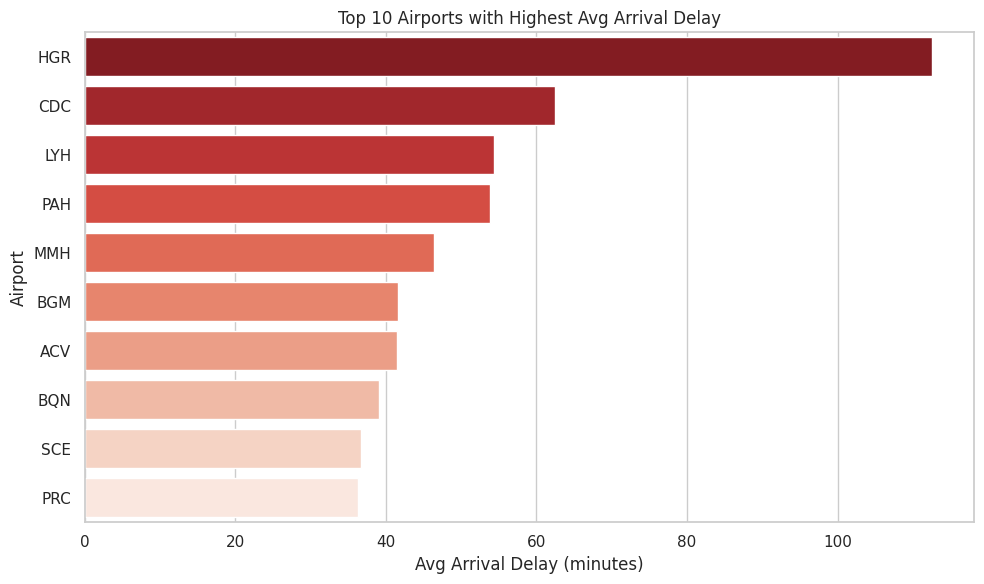

In [54]:
worst_airports = airport_stats.sort_values('avg_arr_delay', ascending=False).head(10)
plt.figure(figsize=(10,6))
sns.barplot(data=worst_airports, x='avg_arr_delay', y='IATA', palette='Reds_r')
plt.title('Top 10 Airports with Highest Avg Arrival Delay')
plt.xlabel('Avg Arrival Delay (minutes)'); plt.ylabel('Airport')
plt.tight_layout()


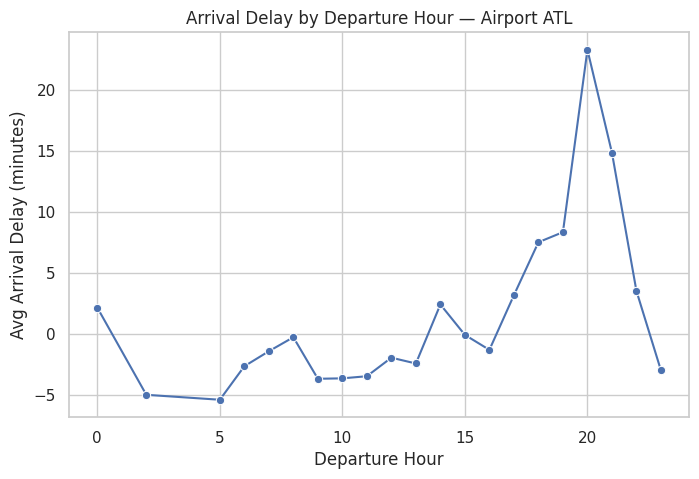

In [55]:
# Pick busiest airport and plot avg delay by hour
busiest_airport = airport_stats.iloc[0]['IATA']
adf = data[data['DEST'] == busiest_airport]
delay_by_hour = adf.groupby('DEP_HOUR')['ARR_DELAY'].mean().reset_index()
plt.figure(figsize=(8,5))
sns.lineplot(data=delay_by_hour, x='DEP_HOUR', y='ARR_DELAY', marker='o')
plt.title(f'Arrival Delay by Departure Hour — Airport {busiest_airport}')
plt.xlabel('Departure Hour'); plt.ylabel('Avg Arrival Delay (minutes)')
plt.grid(True)


Text(0.5, 1.0, 'Average Arrival Delay by Route & Month')

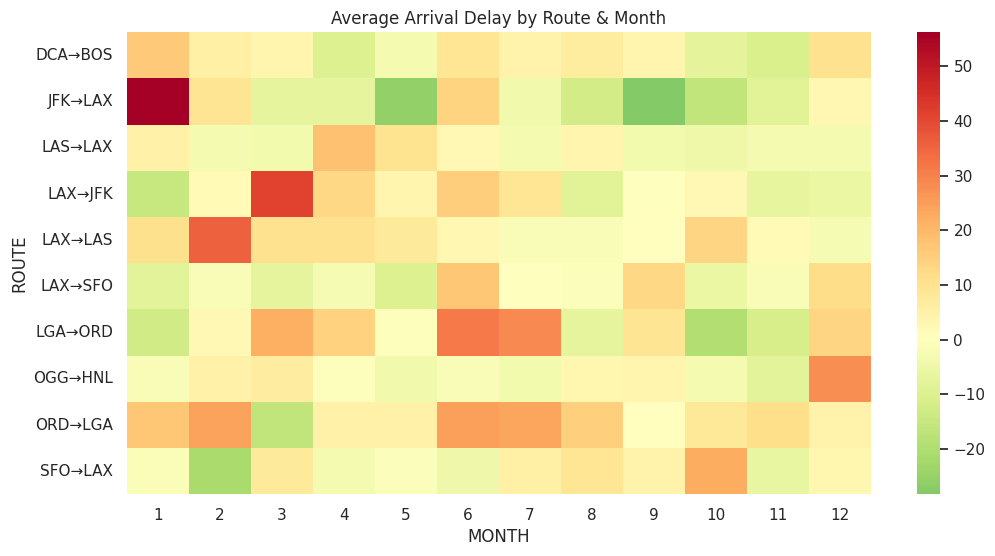

In [56]:
# Heatmap: avg delay by month for top routes
subset = data[data['ROUTE'].isin(top10_routes['ROUTE'])]
pivot = subset.pivot_table(index='ROUTE', columns='MONTH', values='ARR_DELAY', aggfunc='mean')
plt.figure(figsize=(12,6))
sns.heatmap(pivot, cmap='RdYlGn_r', annot=False, center=0)
plt.title('Average Arrival Delay by Route & Month')


/tmp/ipython-input-3854157637.py:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, 'Monday'),
  Text(1, 0, 'Tuesday'),
  Text(2, 0, 'Wednesday'),
  Text(3, 0, 'Thursday'),
  Text(4, 0, 'Friday'),
  Text(5, 0, 'Saturday'),
  Text(6, 0, 'Sunday')])

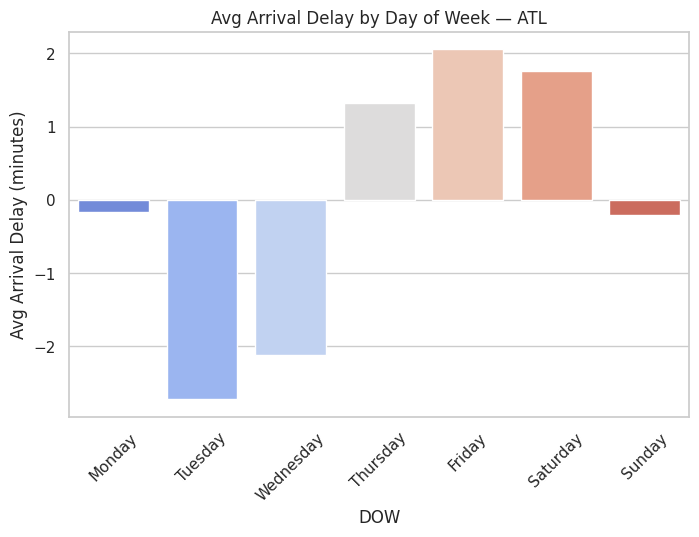

In [57]:
airport = busiest_airport
weekly = data[data['DEST']==airport].groupby('DOW')['ARR_DELAY'].mean().reindex(
    ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
).reset_index()
plt.figure(figsize=(8,5))
sns.barplot(data=weekly, x='DOW', y='ARR_DELAY', palette='coolwarm')
plt.title(f'Avg Arrival Delay by Day of Week — {airport}')
plt.ylabel('Avg Arrival Delay (minutes)')
plt.xticks(rotation=45)


In [58]:
if 'OP_CARRIER' in data.columns:
    topR = data[data['ROUTE'].isin(top10_routes['ROUTE'])]
    plt.figure(figsize=(12,6))
    sns.violinplot(data=topR, x='OP_CARRIER', y='ARR_DELAY', scale='width', inner=None)
    plt.title('Arrival Delay Distribution by Carrier on Top Routes')
    plt.xticks(rotation=45)


In [59]:
# Animated line chart: delay trends by month for top airports
# Check if airport_stats is available and has enough data
if 'airport_stats' in locals() and not airport_stats.empty and len(airport_stats) >= 5:
    # Select top 5 airport IATA codes
    top5_airports_iata = airport_stats['IATA'].head(5).tolist()
    # Filter data for these airports and group by destination and month
    delay_airports = data[data['DEST'].isin(top5_airports_iata)] \
        .groupby(['DEST','MONTH'])['ARR_DELAY'].mean().reset_index()

    # Display the data used for plotting
    print("Data used for plotting:")
    display(delay_airports.head())

    # Create a static line plot initially
    fig = px.line(delay_airports, x='MONTH', y='ARR_DELAY', color='DEST',
                  title='Monthly Avg Delays for Top 5 Airports (Static)')
    fig.show()
else:
    print("Airport stats data not available or not enough data to plot for top 5 airports.")

Data used for plotting:


/tmp/ipython-input-268090582.py:8: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



DEST  MONTH  ARR_DELAY
0  ABE      1        NaN
1  ABE      2        NaN
2  ABE      3        NaN
3  ABE      4        NaN
4  ABE      5        NaN

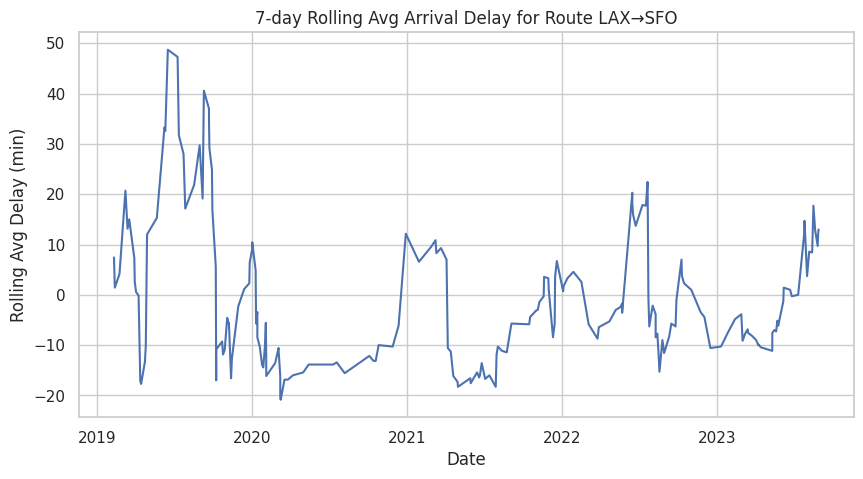

In [60]:
# Rolling mean delay trend for top route
rdata = rdata.sort_values('FLIGHT_DATE')
rdata['rolling_delay'] = rdata['ARR_DELAY'].rolling(7).mean()
plt.figure(figsize=(10,5))
plt.plot(rdata['FLIGHT_DATE'], rdata['rolling_delay'])
plt.title(f'7-day Rolling Avg Arrival Delay for Route {top_route}')
plt.xlabel('Date'); plt.ylabel('Rolling Avg Delay (min)')
plt.grid(True)


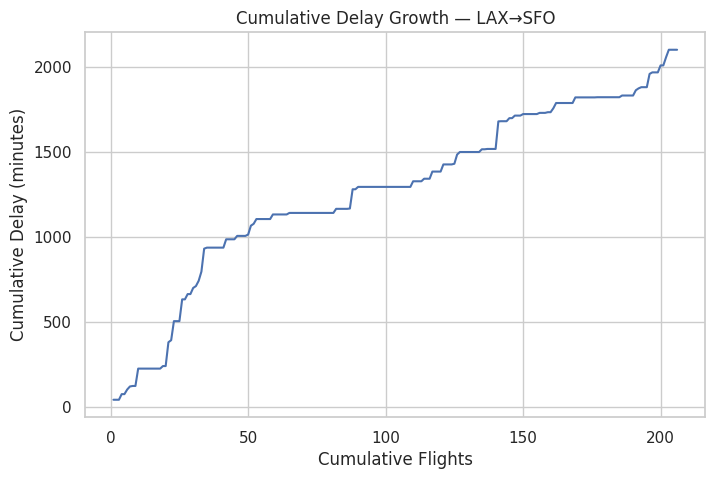

In [61]:
rdata['cum_flights'] = range(1, len(rdata)+1)
rdata['cum_delay'] = rdata['ARR_DELAY'].clip(lower=0).cumsum()
plt.figure(figsize=(8,5))
plt.plot(rdata['cum_flights'], rdata['cum_delay'])
plt.title(f'Cumulative Delay Growth — {top_route}')
plt.xlabel('Cumulative Flights'); plt.ylabel('Cumulative Delay (minutes)')
plt.grid(True)


Text(0.5, 1.0, 'Delay Percentiles — LAX→SFO')

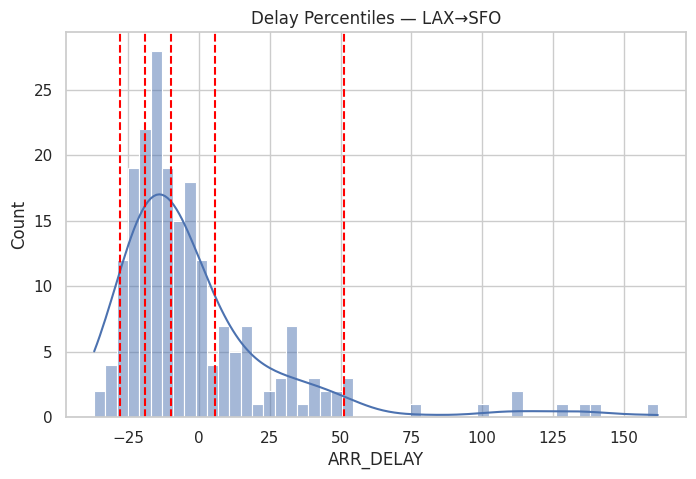

In [62]:
delays = rdata['ARR_DELAY'].dropna()
percentiles = np.percentile(delays, [5,25,50,75,95])
plt.figure(figsize=(8,5))
sns.histplot(delays, bins=50, kde=True)
for p in percentiles:
    plt.axvline(p, linestyle='--', color='red')
plt.title(f'Delay Percentiles — {top_route}')


In [63]:
# Identify flights >3 std dev as outliers
mean, std = rdata['ARR_DELAY'].mean(), rdata['ARR_DELAY'].std()
outliers = rdata[np.abs(rdata['ARR_DELAY']-mean) > 3*std]
print(f"Outliers count: {len(outliers)} / {len(rdata)} ({len(outliers)/len(rdata):.2%})")
outliers[['FLIGHT_DATE','ARR_DELAY']].head()


Outliers count: 7 / 206 (3.40%)


FLIGHT_DATE  ARR_DELAY
54326  2019-03-09      102.0
54337  2019-04-29      140.0
54339  2019-06-09      112.0
54342  2019-06-17      128.0
54350  2019-09-10      135.0

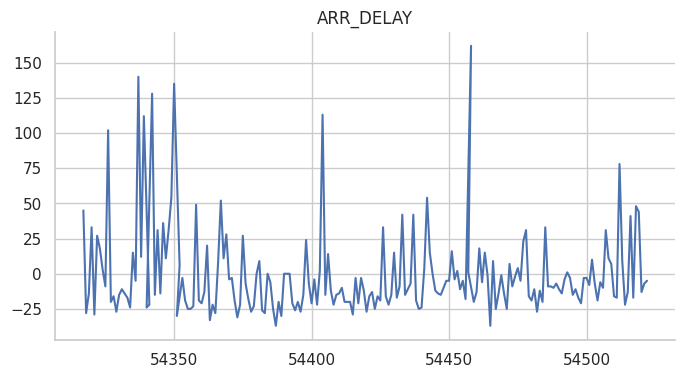

In [65]:
from matplotlib import pyplot as plt
rdata['ARR_DELAY'].plot(kind='line', figsize=(8, 4), title='ARR_DELAY')
plt.gca().spines[['top', 'right']].set_visible(False)

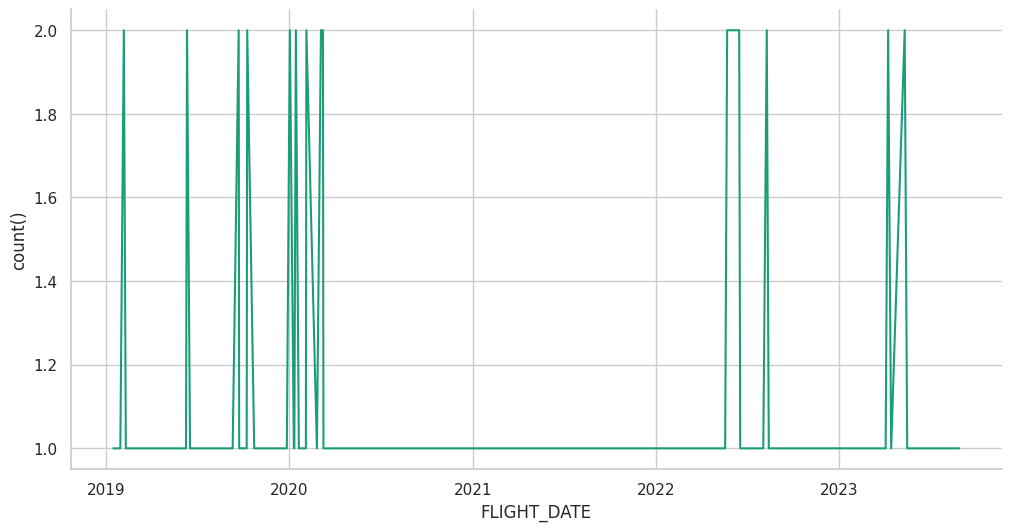

In [68]:
from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['FLIGHT_DATE']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'FLIGHT_DATE'}, axis=1)
              .sort_values('FLIGHT_DATE', ascending=True))
  xs = counted['FLIGHT_DATE']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = rdata.sort_values('FLIGHT_DATE', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('FLIGHT_DATE')
_ = plt.ylabel('count()')

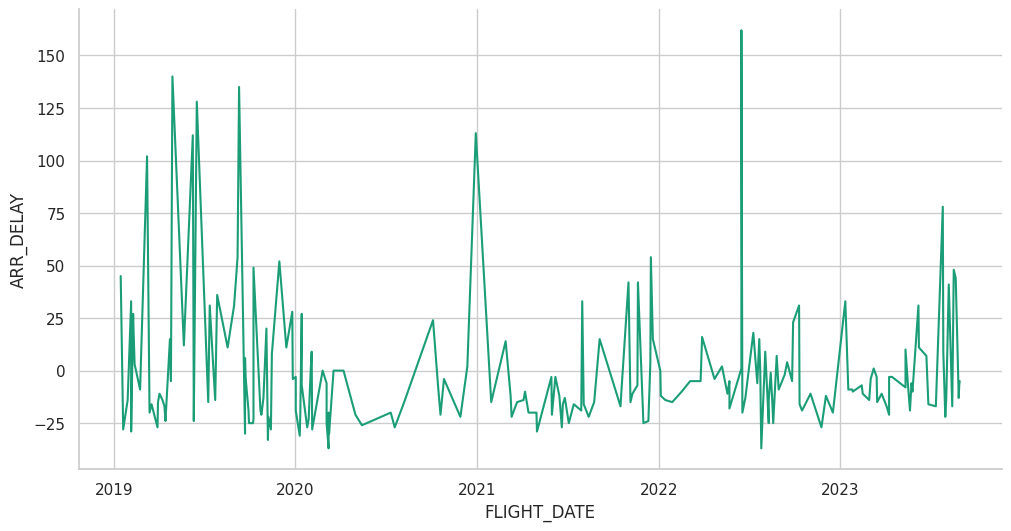

In [71]:
from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['FLIGHT_DATE']
  ys = series['ARR_DELAY']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = rdata.sort_values('FLIGHT_DATE', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('FLIGHT_DATE')
_ = plt.ylabel('ARR_DELAY')

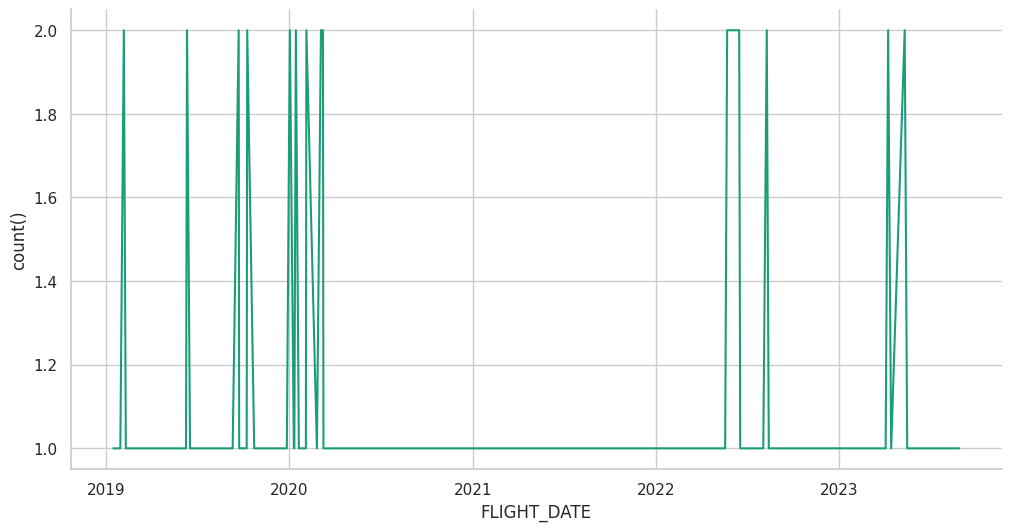

In [72]:
from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['FLIGHT_DATE']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'FLIGHT_DATE'}, axis=1)
              .sort_values('FLIGHT_DATE', ascending=True))
  xs = counted['FLIGHT_DATE']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = rdata.sort_values('FLIGHT_DATE', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('FLIGHT_DATE')
_ = plt.ylabel('count()')

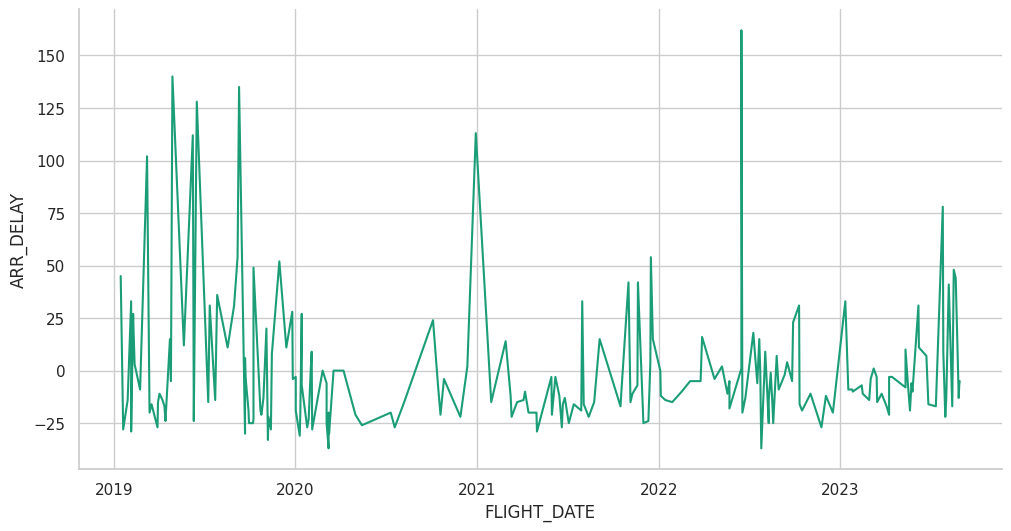

In [75]:
from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['FLIGHT_DATE']
  ys = series['ARR_DELAY']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = rdata.sort_values('FLIGHT_DATE', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('FLIGHT_DATE')
_ = plt.ylabel('ARR_DELAY')

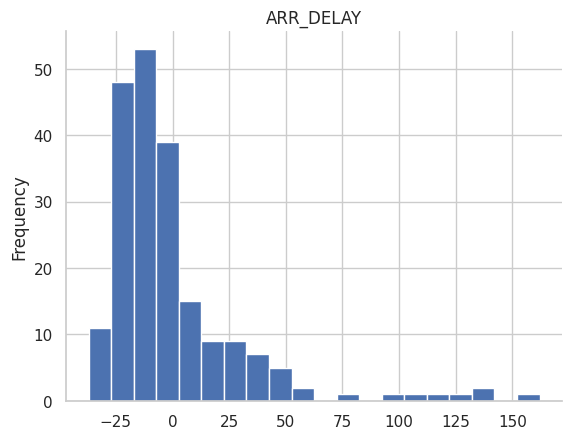

In [76]:
from matplotlib import pyplot as plt
rdata['ARR_DELAY'].plot(kind='hist', bins=20, title='ARR_DELAY')
plt.gca().spines[['top', 'right',]].set_visible(False)

Text(0.5, 1.0, 'Arrival Delays: Busiest (ATL) vs Quietest (ILG) Airport')

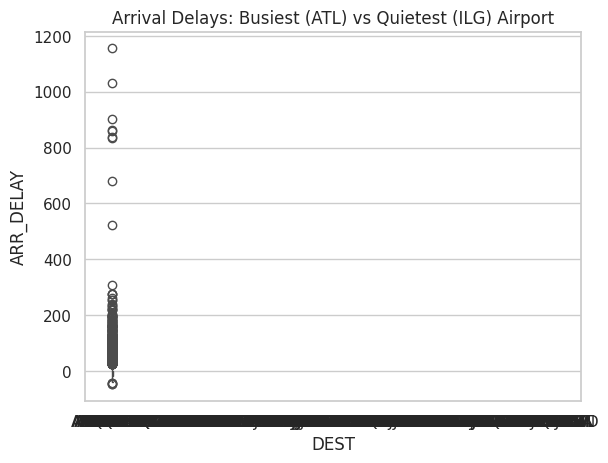

In [74]:
busiest = airport_stats.iloc[0]['IATA']
quietest = airport_stats.iloc[-1]['IATA']
compare = data[data['DEST'].isin([busiest,quietest])]
sns.boxplot(data=compare, x='DEST', y='ARR_DELAY')
plt.title(f'Arrival Delays: Busiest ({busiest}) vs Quietest ({quietest}) Airport')
